# Demand Forecasting 

The objective of this project is to minimize wastage of meal kits in retail stores. Currently, this is being done by tracking each individual item from the source until the point of sale. This is a cumbersome process and is labor intensive. In order to realize the objective using machine learning the first step in the process is to have an accurate forecast of the demand. This project focuses on generating accurate forecast for each individual item (46 unique items) for each store (47 unique stores). There are three datasets that have been used for demand forecasting.

* Product dataset
    - Product_ID 	
    - Cook Products 	
    - Sales Product 	
    - ShelfLife_after_Cook 	
    - ShelfLife_WFM 	
    - Price 	
    - Cost
* Locations dataset
    - Cook_Loc 	
    - Sales_Loc 	
    - Market
    
* Sales dataset
    - Locationno	
    - Market	
    - Saledate 	
    - Productid 	
    - Unit_gross_sales
    
**Note: The unaltered dataset is not shared. Locations dataset contains features obtained from https://censusreporter.org/ not present in the original dataset**

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # visualization
import seaborn as sns  # visualization
import holidays   # stored list of holidays in U.S.

# Model
import lightgbm as lgb
import shap                  # For error analysis
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder       

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Read the dataset containing the products and sales of the products across the stores in the state of Texas

prod = pd.read_csv('WFM_Products', delimiter = '\t')
locations = pd.read_csv("locations.csv")
sales = pd.read_csv('WFM_Sales.txt', delimiter = '\t',  usecols = ['LOCATIONNO', 'MARKET', 'SALEDATE',
        'PRODUCTID', 'UNIT_GROSS_SALES'],
                    parse_dates = ['SALEDATE'])

# Data Cleaning

Product dataset contains 9 missing values in the cost column. Client provided information for 4 of the nine missing values. Rest of the products were third party products thus were deemed unnecessary for the analysis. The price column contains '$' symbol which was replaced and converted from string to float.

In [3]:
prod.isna().sum()

Product_ID              0
Cook Products           0
Sales Product           0
ShelfLife_after_Cook    0
ShelfLife_WFM           0
Price                   0
Cost                    9
dtype: int64

In [4]:
miss = {900979: 2.37, 901974: 1.78, 902588: 2.66, 
902901: 2.15 }

for key, val in miss.items():
    for i in prod['Product_ID']:
#         print(i)
        if i == key:
            prod.at[prod[prod['Product_ID'] == i].index[0],'Cost'] = val

        
prod.dropna(inplace = True)
i = prod[prod['Product_ID']== 902901].index
prod.drop(i, inplace = True)
prod['Price'] = prod['Price'].str.replace('$', '').astype(float)

The third party items were removed from the sales column as well.

In [5]:
sales['Cost'] = sales['PRODUCTID'].map(prod.set_index('Product_ID')['Cost'])
index_names = sales[(sales['PRODUCTID'] == 902729) | (sales['PRODUCTID'] == 902322) | (sales['PRODUCTID'] == 902787) |
                   (sales['PRODUCTID'] == 902901) | (sales['PRODUCTID'] == 902323) | (sales['PRODUCTID'] == 902733) |
                   (sales['PRODUCTID'] == 902730) | (sales['PRODUCTID'] == 902732) | (sales['PRODUCTID'] == 902911) |
                    (sales['PRODUCTID'] == 901902) | (sales['PRODUCTID'] == 902547) | (sales['PRODUCTID'] == 902546)].index

sales.drop(index_names, inplace = True)
sales.dropna(inplace = True)

In [6]:
print(sales.shape, "\n")
sales.head()

(290014, 6) 



,LOCATIONNO,MARKET,SALEDATE,PRODUCTID,UNIT_GROSS_SALES,Cost
1,10073,Austin,2019-09-08,902287,1.0,1.82
2,10086,Austin,2019-09-08,901352,1.0,2.28
4,10017,Austin,2019-09-08,901352,1.0,2.28
5,10085,Austin,2019-09-08,902714,1.0,1.96
6,10073,Austin,2019-09-08,902934,1.0,0.96


In [7]:
# How many stores and items are there?
print("number of unique items :",sales.PRODUCTID.nunique())
print("number of unique store :",sales.LOCATIONNO.nunique())

number of unique items : 46
number of unique store : 47


In [8]:
# Time Range
sales["SALEDATE"].min(), sales["SALEDATE"].max()

(Timestamp('2019-09-08 00:00:00'), Timestamp('2021-04-06 00:00:00'))

In [9]:
# How many items are in the store?
le = LabelEncoder()
sales['LOCATIONNO'] = le.fit_transform(sales['LOCATIONNO'].values)
inverse_loc = le.inverse_transform(sales['LOCATIONNO'])
trans_loc = sales['LOCATIONNO']
sales['PRODUCTID'] = le.fit_transform(sales['PRODUCTID'].values)
sales.groupby(["LOCATIONNO"])["PRODUCTID"].nunique()

LOCATIONNO
0     46
1     46
2     46
3     46
4     36
5     45
6     45
7     46
8     46
9     45
10    46
11    46
12    46
13    45
14    46
15    45
16    45
17    46
18    46
19    46
20    46
21    46
22    46
23    46
24    46
25    46
26    46
27    45
28    46
29    46
30    46
31    45
32    46
33    46
34    46
35    45
36    46
37    45
38    46
39    46
40    46
41    46
42    45
43    46
44    46
45    46
46    45
Name: PRODUCTID, dtype: int64

In [10]:
# Summary Stats for each store
sales.groupby(["LOCATIONNO"]).agg({"UNIT_GROSS_SALES": ["count","sum", "mean", 
                                                        "median", "std", "min", "max"]})

UNIT_GROSS_SALES                                                
                      count       sum      mean median       std  min   max
LOCATIONNO                                                                 
0                      7466  22435.23  3.004987    2.0  2.688379  0.0  25.0
1                      6624  15233.00  2.299668    2.0  1.962819  0.0  14.0
2                      7430  18278.17  2.460050    2.0  2.107790  0.0  16.0
3                      6367  11731.00  1.842469    1.0  1.621748  0.0  14.0
4                      4890  17768.00  3.633538    3.0  3.411545  0.0  36.0
5                      5095   8027.75  1.575613    1.0  1.507925  0.0  13.0
6                      5224   8745.00  1.674005    1.0  1.619680  0.0  14.0
7                      5487   9790.80  1.784363    1.0  1.819337  0.0  20.0
8                      5358  10026.00  1.871221    1.0  1.705230  0.0  12.0
9                      5097   6627.00  1.300177    1.0  1.319514  0.0   9.0
10                     4956   7925.70  1.599213    1.0  1.520835  0.0  11.0
11                     4520   5239.00  1.159071    1.0  1.248378  0.0  10.0
12                     6262  19845.88  3.169256    2.0  2.914780  0.0  30.0
13                     4651   5736.00  1.233283    1.0  1.275230  0.0  12.0
14                     5726  13203.00  2.305798    2.0  2.081381  0.0  16.0
15                     5738  12329.29  2.148709    2.0  2.003545  0.0  16.1
16                     5379   9544.90  1.774475    1.0  1.721056  0.0  18.0
17                     6903  16933.00  2.452991    2.0  2.094687  0.0  16.0
18                     6389  12324.00  1.928940    2.0  1.671323  0.0  20.0
19                     7158  17659.00  2.467030    2.0  2.074877  0.0  15.0
20                     6254  10149.00  1.622801    1.0  1.457495  0.0  12.0
21                     6634  12702.00  1.914682    2.0  1.650885  0.0  13.0
22                     6617  10787.00  1.630195    1.0  1.533882  0.0  15.0
23                     6887  12882.00  1.870481    2.0  1.617796  0.0  14.0
24                     6988  17344.00  2.481969    2.0  2.162589  0.0  18.0
25                     6381  11172.00  1.750823    1.0  1.573079  0.0  16.0
26                     6736  14235.00  2.113272    2.0  1.740413  0.0  12.0
27                     6319  13571.00  2.147650    2.0  2.002659  0.0  16.0
28                     6318  10464.00  1.656220    1.0  1.418869  0.0  11.0
29                     5911   9410.42  1.592018    1.0  1.396673  0.0  15.0
30                     8480  49427.82  5.828752    4.0  5.271472  0.0  85.0
31                     5992   8855.00  1.477804    1.0  1.367350  0.0  18.0
32                     7301  17564.35  2.405746    2.0  2.044244  0.0  25.0
33                     7849  24421.02  3.111354    3.0  2.600314  0.0  22.0
34                     5941   7162.00  1.205521    1.0  1.216750  0.0  11.0
35                     5561   8248.25  1.483231    1.0  1.373421  0.0  12.0
36                     5699  11326.00  1.987366    1.0  2.049454  0.0  29.0
37                     5653   7343.00  1.298956    1.0  1.254628  0.0   9.0
38                     6153  11187.00  1.818137    1.0  1.590339  0.0  13.0
39                     6677  15645.00  2.343118    2.0  2.166764  0.0  22.0
40                     6492  11928.00  1.837338    2.0  1.541209  0.0  14.0
41                     6305  11331.00  1.797145    1.0  1.547141  0.0  12.0
42                     6215  13815.00  2.222848    2.0  2.045364  0.0  15.0
43                     5702   7844.00  1.375658    1.0  1.373397  0.0  12.0
44                     6511  12741.73  1.956954    2.0  1.667920  0.0  18.0
45                     6309  10392.00  1.647171    1.0  1.557735  0.0  13.0
46                     5409   7842.00  1.449806    1.0  1.300789  0.0  12.0

In [11]:
# Summary Stats for each item
sales.groupby(["PRODUCTID"]).agg({"UNIT_GROSS_SALES": ["count","sum", "mean", "median",
                                                       "std", "min", "max"]})

UNIT_GROSS_SALES                                                 
                     count       sum      mean median       std   min   max
PRODUCTID                                                                  
0                      881   1489.00  1.690125    1.0  1.149310  1.00  12.0
1                    15271  39342.84  2.576311    2.0  2.507954  0.00  28.0
2                     8558  23905.00  2.793293    2.0  2.145337  0.00  22.0
3                    18194  51367.75  2.823335    2.0  2.821902  0.00  59.0
4                      100    165.00  1.650000    1.0  1.192358  1.00   7.0
5                     6961  15097.77  2.168908    2.0  1.496724  0.42  16.0
6                     5752  13468.00  2.341446    2.0  1.631576  0.00  13.0
7                     3199   5679.00  1.775242    1.0  1.152993  0.00  13.0
8                     8967  21627.71  2.411923    2.0  2.707817  0.00  27.0
9                     4387   7152.65  1.630419    1.0  0.942318  0.00   7.0
10                    1002   1627.00  1.623752    1.0  1.042146  1.00   9.0
11                    8836  12853.00  1.454617    0.0  2.310401  0.00  25.0
12                    3086   5614.00  1.819183    1.0  1.048439  1.00   7.0
13                    8958  17678.39  1.973475    1.0  2.339349  0.00  27.0
14                     843   1317.00  1.562278    1.0  0.915348  1.00   7.0
15                    6124  14881.00  2.429948    2.0  1.885544  0.00  22.0
16                   11353  30249.00  2.664406    2.0  1.953958  0.00  25.0
17                    4306   9994.81  2.321136    2.0  1.703804  0.11  15.0
18                    2591   5086.00  1.962949    2.0  1.313200  1.00  11.0
19                    1987   5283.00  2.658782    2.0  2.037989  0.00  18.0
20                    5255   9629.00  1.832350    1.0  1.116143  1.00  11.0
21                    1106   1902.50  1.720163    1.0  1.057462  1.00   8.5
22                    6964  14536.00  2.087306    2.0  1.387399  0.00  14.0
23                    2839   4561.00  1.606552    1.0  0.924477  0.00  11.0
24                    3504   6131.00  1.749715    1.0  1.033758  1.00   8.0
25                    5595  11575.00  2.068811    2.0  1.299769  0.00  10.0
26                    3078   5623.00  1.826836    2.0  1.059599  0.00   9.0
27                   13402  35149.25  2.622687    2.0  2.708546  0.00  35.0
28                    4546  10005.00  2.200836    2.0  1.461169  0.00  14.0
29                    3925   7301.00  1.860127    1.0  1.145417  1.00   8.0
30                    1498   3500.00  2.336449    2.0  1.517748  1.00  13.0
31                     755   1435.00  1.900662    1.0  1.301677  0.00   9.0
32                    1358   2502.00  1.842415    1.0  1.160730  0.00  11.0
33                    6111  13937.90  2.280789    2.0  1.605280  0.00  19.0
34                   13443  31241.59  2.324004    2.0  2.274236  0.00  26.0
35                    5769  11913.00  2.065003    2.0  1.470268  0.00  15.0
36                     836   1309.00  1.565789    1.0  0.973531  1.00   7.0
37                   13299  30004.98  2.256183    2.0  2.299639  0.00  57.0
38                   13522  33390.15  2.469320    2.0  2.412362  0.00  29.0
39                    8837   9548.00  1.080457    0.0  1.863488  0.00  22.0
40                    8836  10658.50  1.206258    0.0  1.859811  0.00  23.0
41                    8836  18154.00  2.054550    1.0  3.142165  0.00  85.0
42                    8836  19553.76  2.212965    1.0  3.178544  0.00  43.0
43                    8836  13038.76  1.475641    0.0  2.216686  0.00  31.0
44                    8836   9877.00  1.117813    0.0  1.928911  0.00  25.0
45                    8836   8837.00  1.000113    0.0  1.571769  0.00  15.0

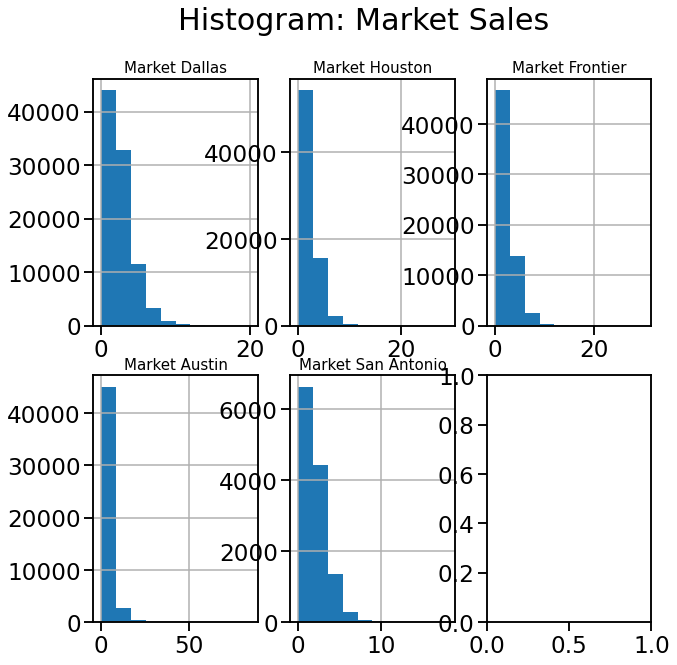

In [12]:
sns.set_context("talk", font_scale=1.4)
markets = ['Dallas', 'Houston', 'Frontier', 'Austin', 'San Antonio']

fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for i in range(len(markets)):
    if i < 3:
        sales[sales.MARKET == markets[i]].UNIT_GROSS_SALES.hist(ax=axes[0, i])
        axes[0,i].set_title("Market " + markets[i], fontsize = 15)
    else:
        sales[sales.MARKET == markets[i]].UNIT_GROSS_SALES.hist(ax=axes[1, i-3])
        axes[1,i-3].set_title("Market " + markets[i], fontsize = 15)
        
plt.tight_layout(pad= 4.5)
plt.suptitle("Histogram: Market Sales");

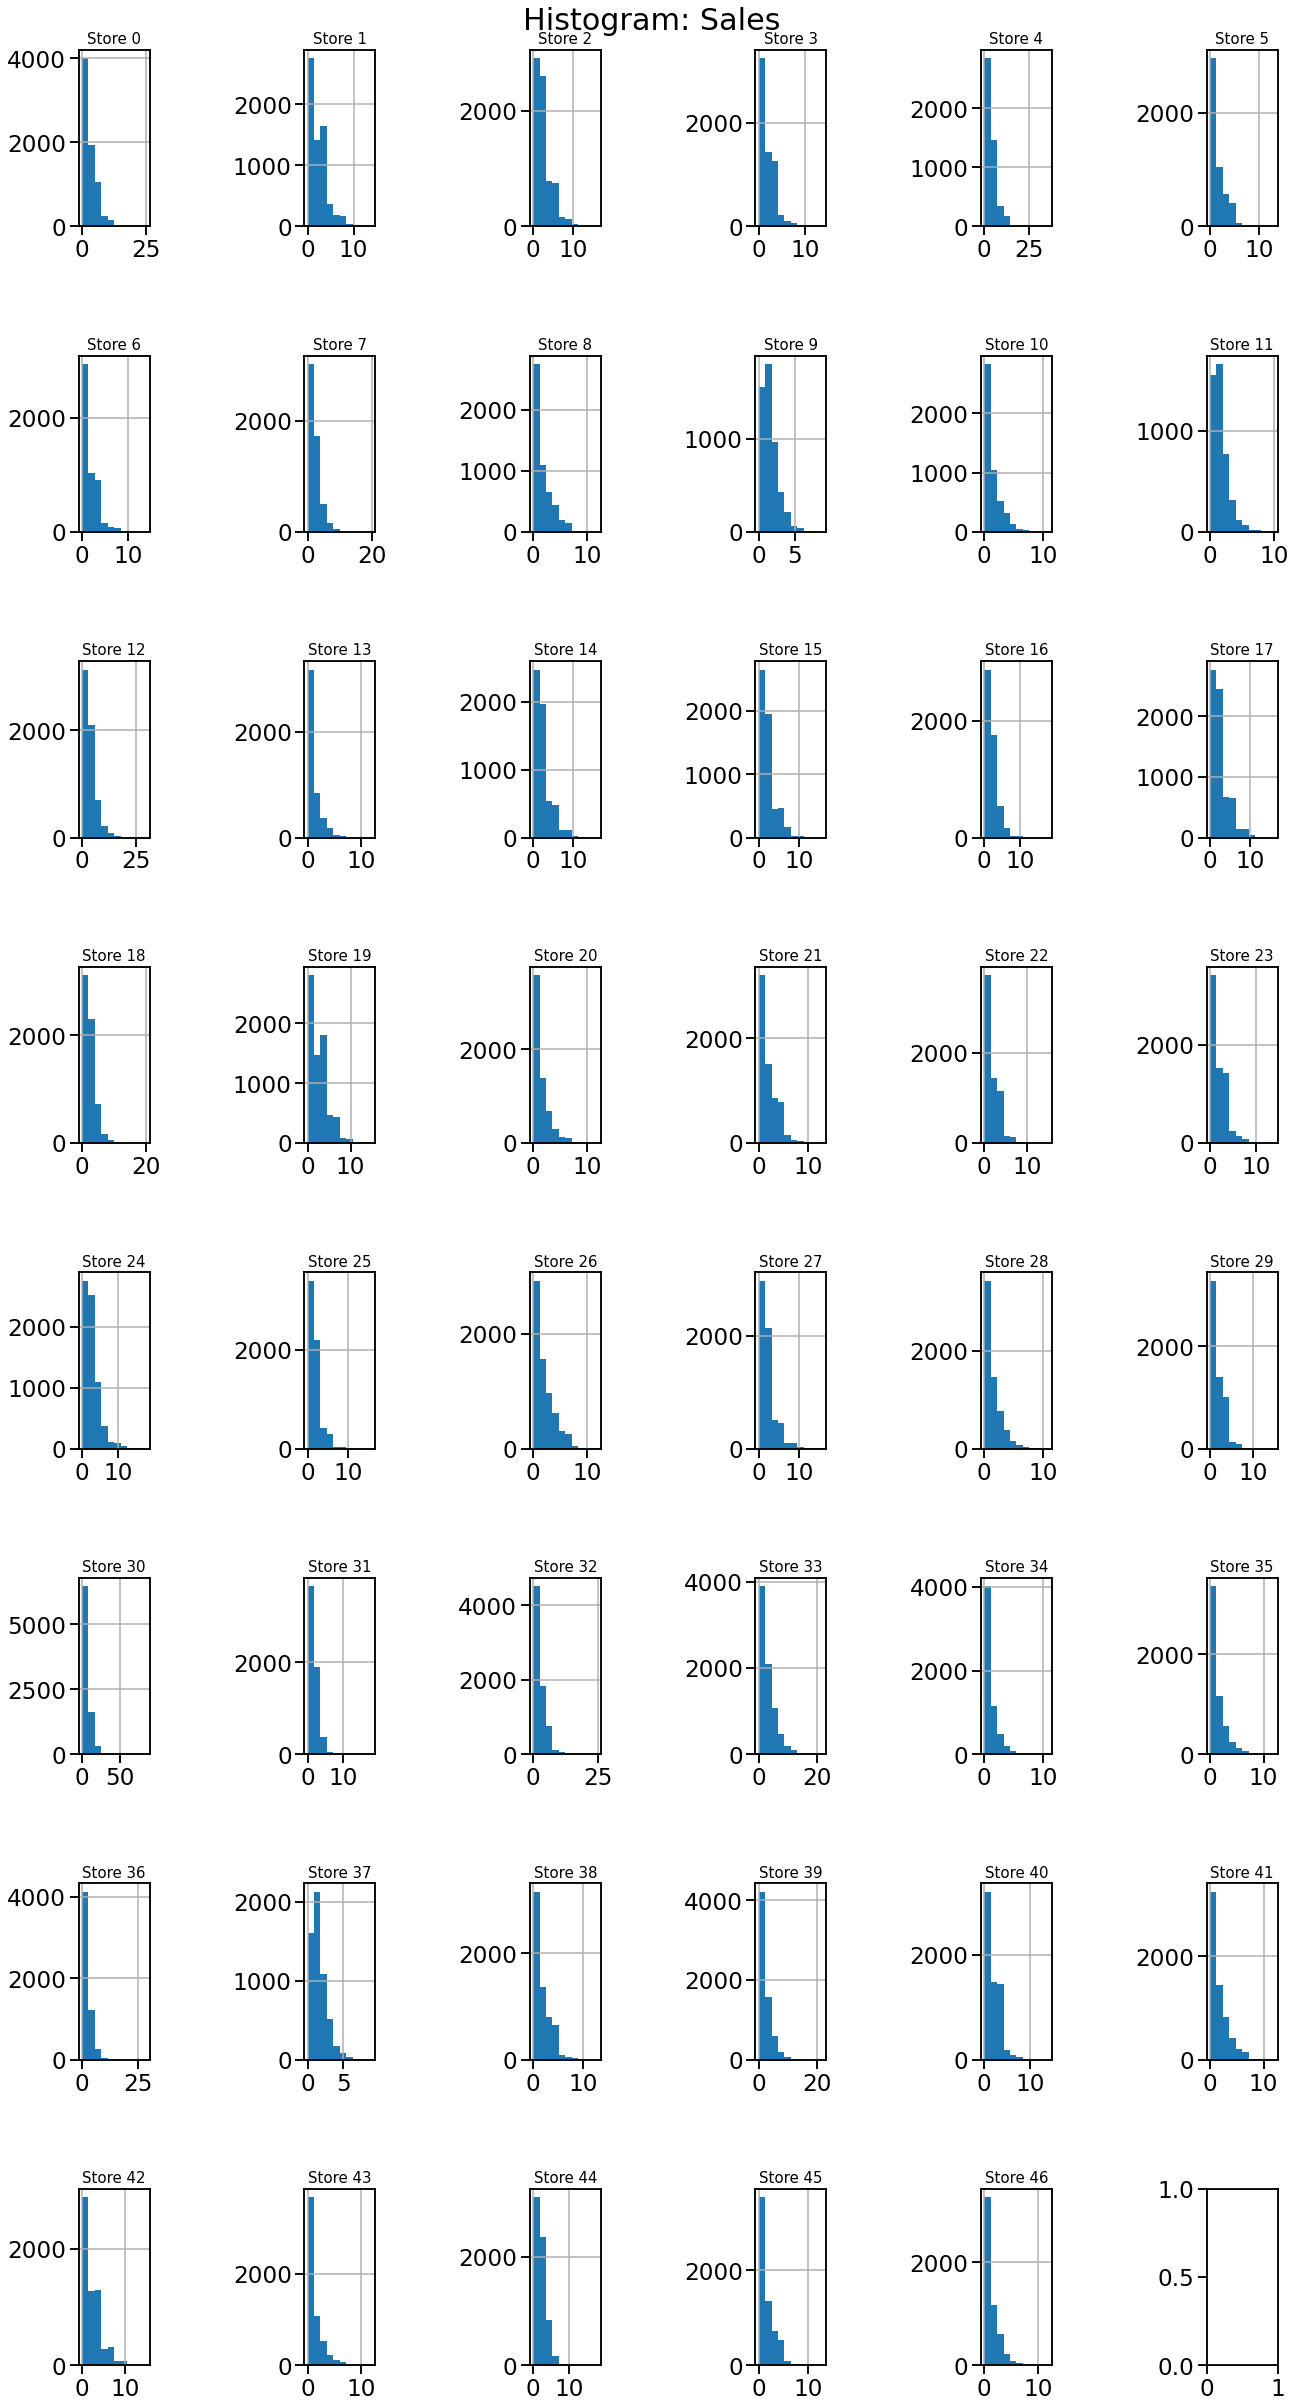

In [22]:
# Histogram Sales
sns.set_context("talk", font_scale=1.4)
fig, axes = plt.subplots(8, 6, figsize=(20, 35))
for i in range(0,47):
    if i < 6:
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[0, i])
        axes[0,i].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 5) & (i < 12):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 11) & (i < 18): 
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[2, i - 12])
        axes[2,i-12].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 17) & (i < 24):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[3, i - 18])
        axes[3,i-18].set_title("Store " + str(i), fontsize = 15)
    
    elif (i > 23) & (i < 30):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[4, i - 24])
        axes[4,i-24].set_title("Store " + str(i), fontsize = 15)
    
    elif (i > 29) & (i < 36):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[5, i - 30])
        axes[5,i-30].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 35) & (i < 42):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[6, i - 36])
        axes[6,i-36].set_title("Store " + str(i), fontsize = 15)
    
    else:
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[7, i - 42])
        axes[7,i-42].set_title("Store " + str(i), fontsize = 15)
        
plt.tight_layout(pad= 3)
plt.suptitle("Histogram: Sales");

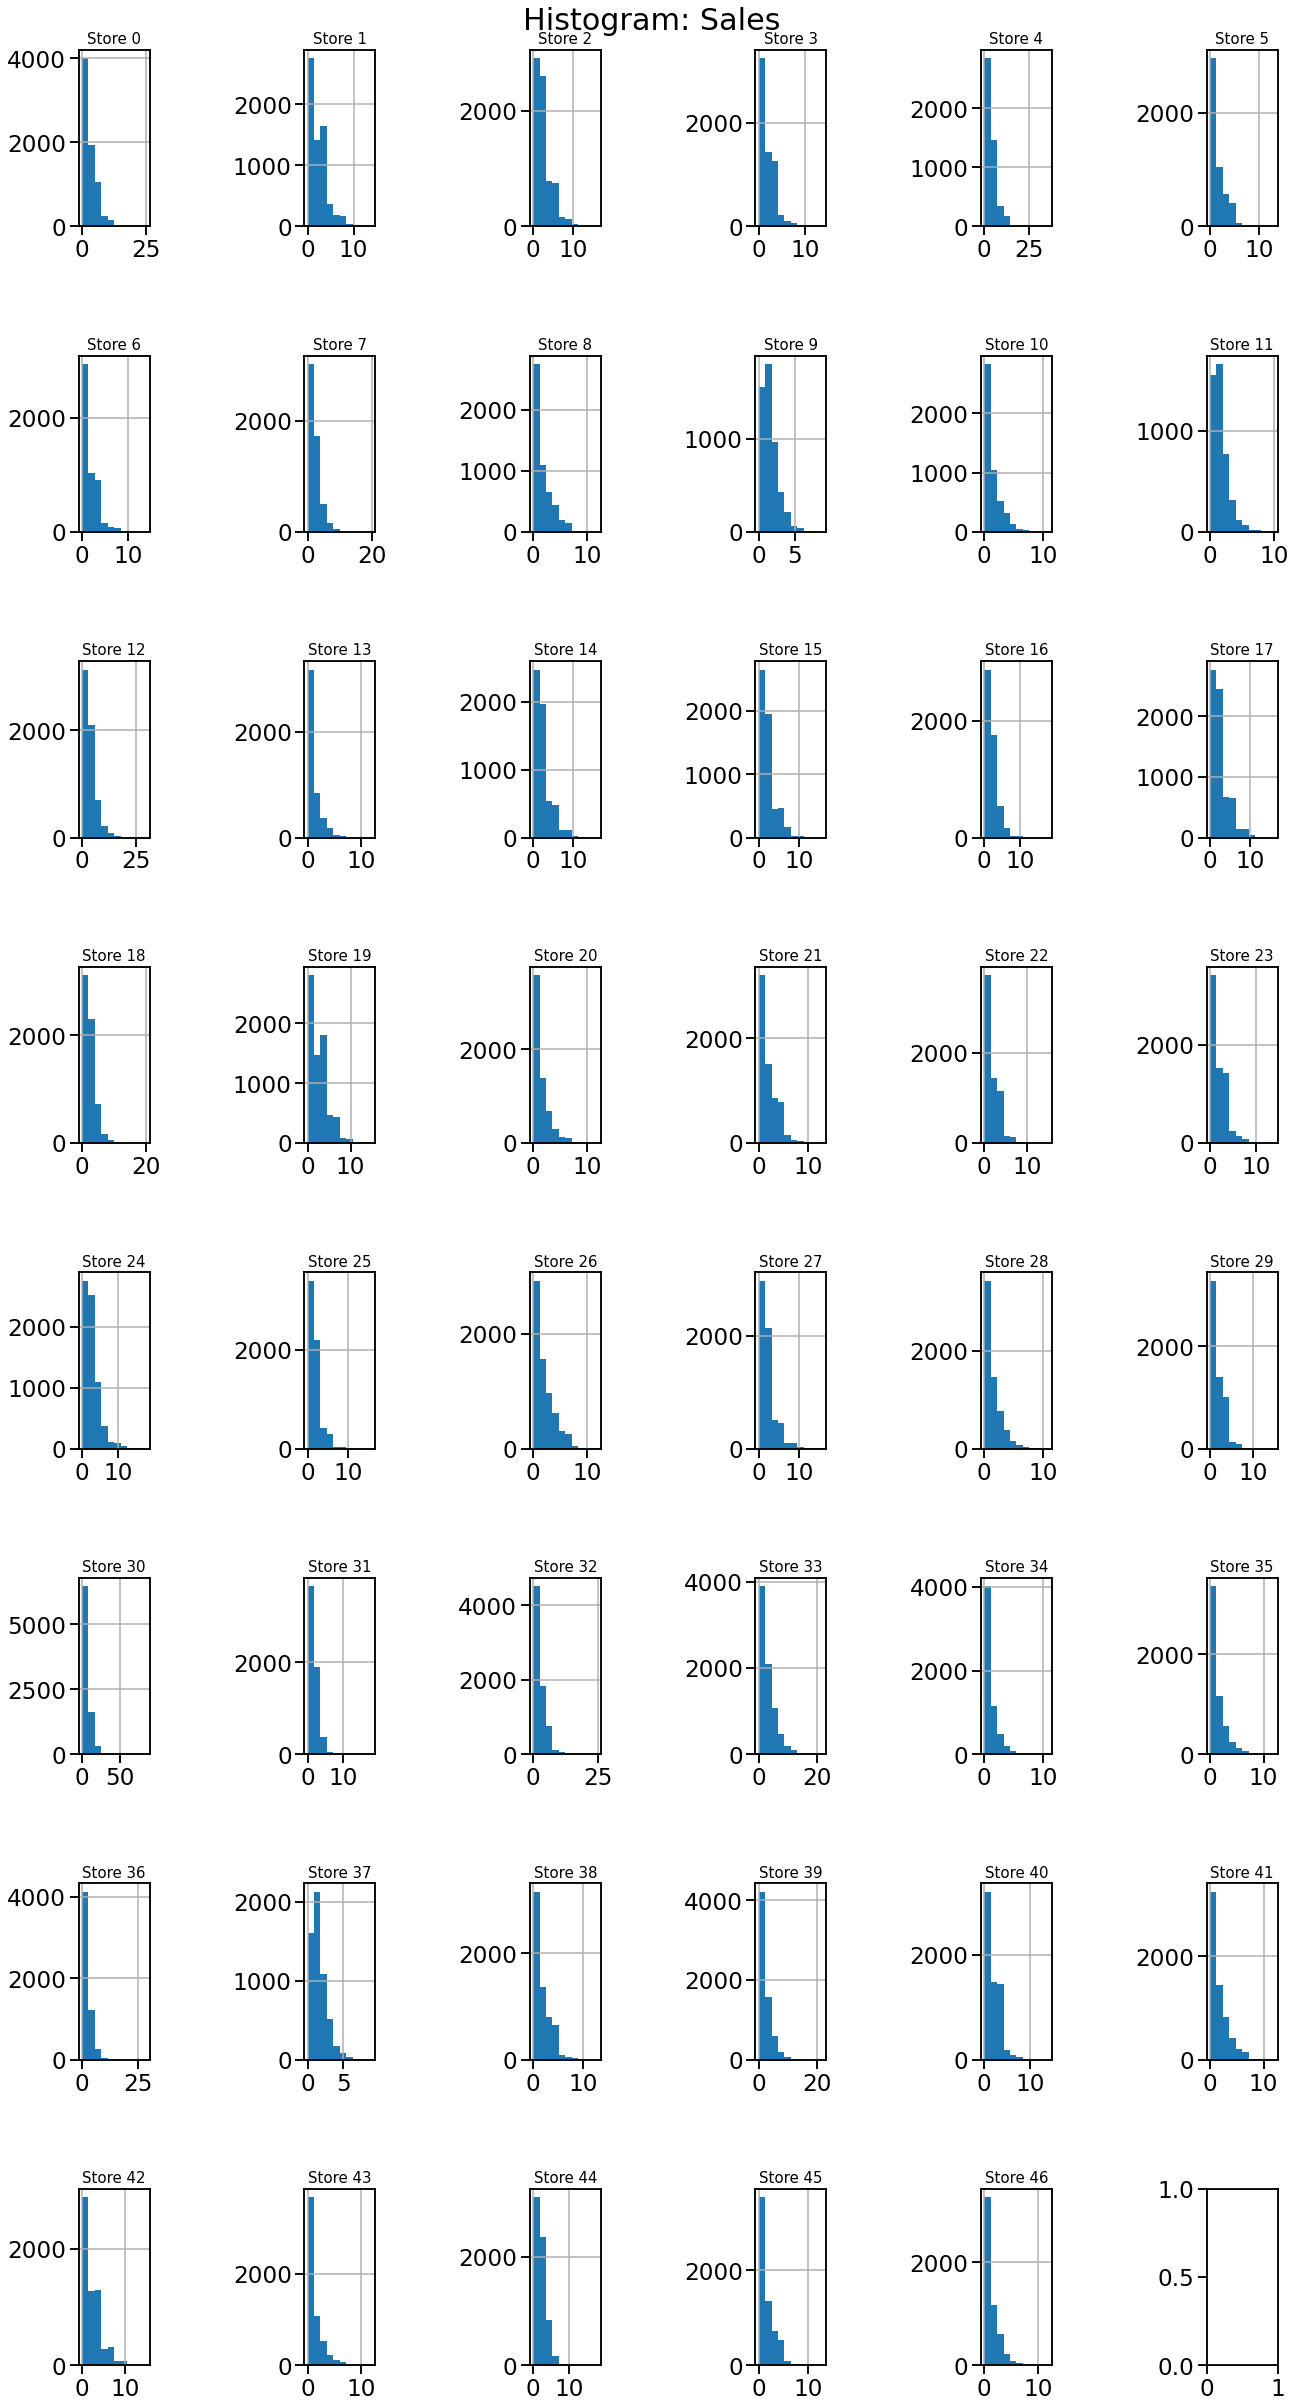

In [23]:
# Histogram Sales
sns.set_context("talk", font_scale=1.4)
fig, axes = plt.subplots(8, 6, figsize=(20, 35))
for i in range(0,47):
    if i < 6:
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[0, i])
        axes[0,i].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 5) & (i < 12):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 11) & (i < 18): 
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[2, i - 12])
        axes[2,i-12].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 17) & (i < 24):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[3, i - 18])
        axes[3,i-18].set_title("Store " + str(i), fontsize = 15)
    
    elif (i > 23) & (i < 30):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[4, i - 24])
        axes[4,i-24].set_title("Store " + str(i), fontsize = 15)
    
    elif (i > 29) & (i < 36):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[5, i - 30])
        axes[5,i-30].set_title("Store " + str(i), fontsize = 15)
        
    elif (i > 35) & (i < 42):
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[6, i - 36])
        axes[6,i-36].set_title("Store " + str(i), fontsize = 15)
    
    else:
        sales[sales.LOCATIONNO == i].UNIT_GROSS_SALES.hist(ax=axes[7, i - 42])
        axes[7,i-42].set_title("Store " + str(i), fontsize = 15)
        
plt.tight_layout(pad= 3)
plt.suptitle("Histogram: Sales");

The following plot shows the sale of all the items in store 1.

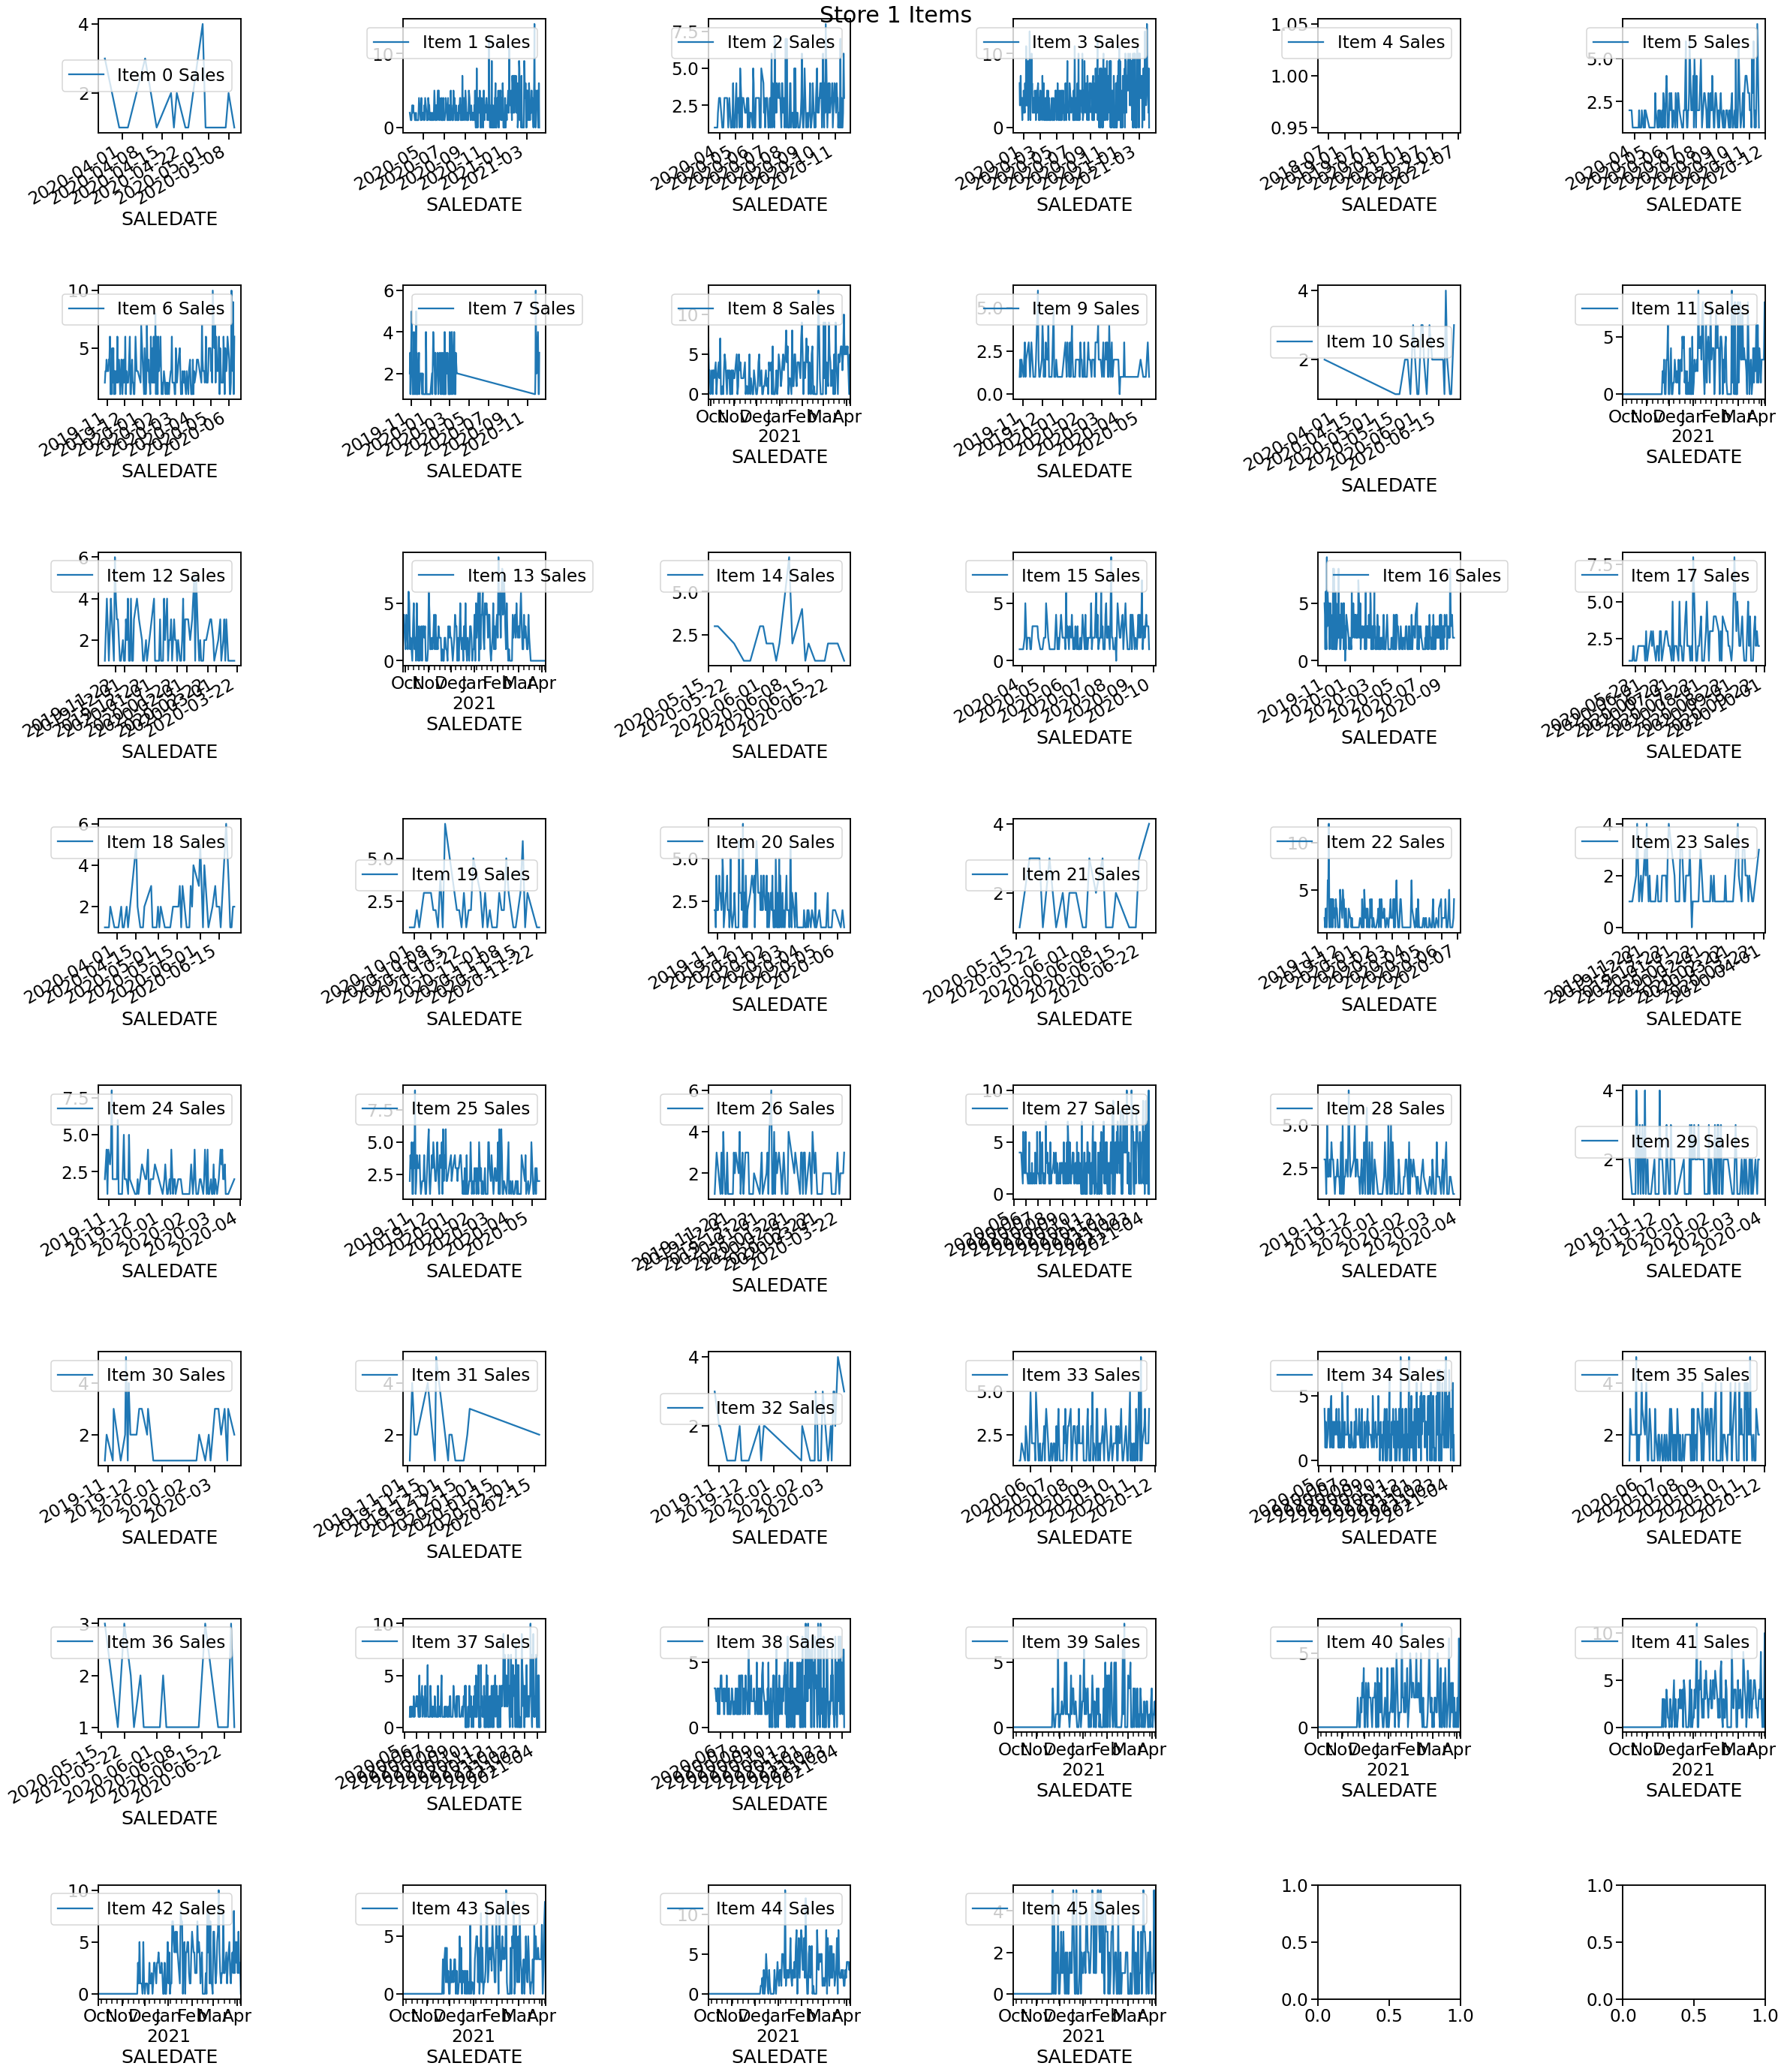

In [25]:
store = 1
sub = sales[sales.LOCATIONNO == store].set_index("SALEDATE")

# sns.set_context("talk", font_scale=1.4)
fig, axes = plt.subplots(8, 6, figsize=(35, 40))
for i in range(0,46):
    if i < 6:
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[0, i], 
                                      legend=True, label = "Item "+str(i)+" Sales")
    elif (i > 5) & (i < 12):
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[1, i - 6], 
                                      legend=True, label = "Item "+str(i)+" Sales")
    elif (i > 11) & (i < 18):
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[2, i - 12], 
                                      legend=True, label = "Item "+str(i)+" Sales")    
    elif (i > 17) & (i < 24):
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[3, i - 18], 
                                      legend=True, label = "Item "+str(i)+" Sales")    
    elif (i > 23) & (i < 30):
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[4, i - 24], 
                                      legend=True, label = "Item "+str(i)+" Sales")  
    elif (i > 29) & (i < 36):
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[5, i - 30], 
                                      legend=True, label = "Item "+str(i)+" Sales")    
    elif (i > 35) & (i < 42):
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[6, i - 36], 
                                      legend=True, label = "Item "+str(i)+" Sales")    
    else:
        sub[sub.PRODUCTID == i].UNIT_GROSS_SALES.plot(ax=axes[7, i - 42], 
                                      legend=True, label = "Item "+str(i)+" Sales")    

plt.tight_layout(pad=3)
plt.suptitle("Store 1 Items");

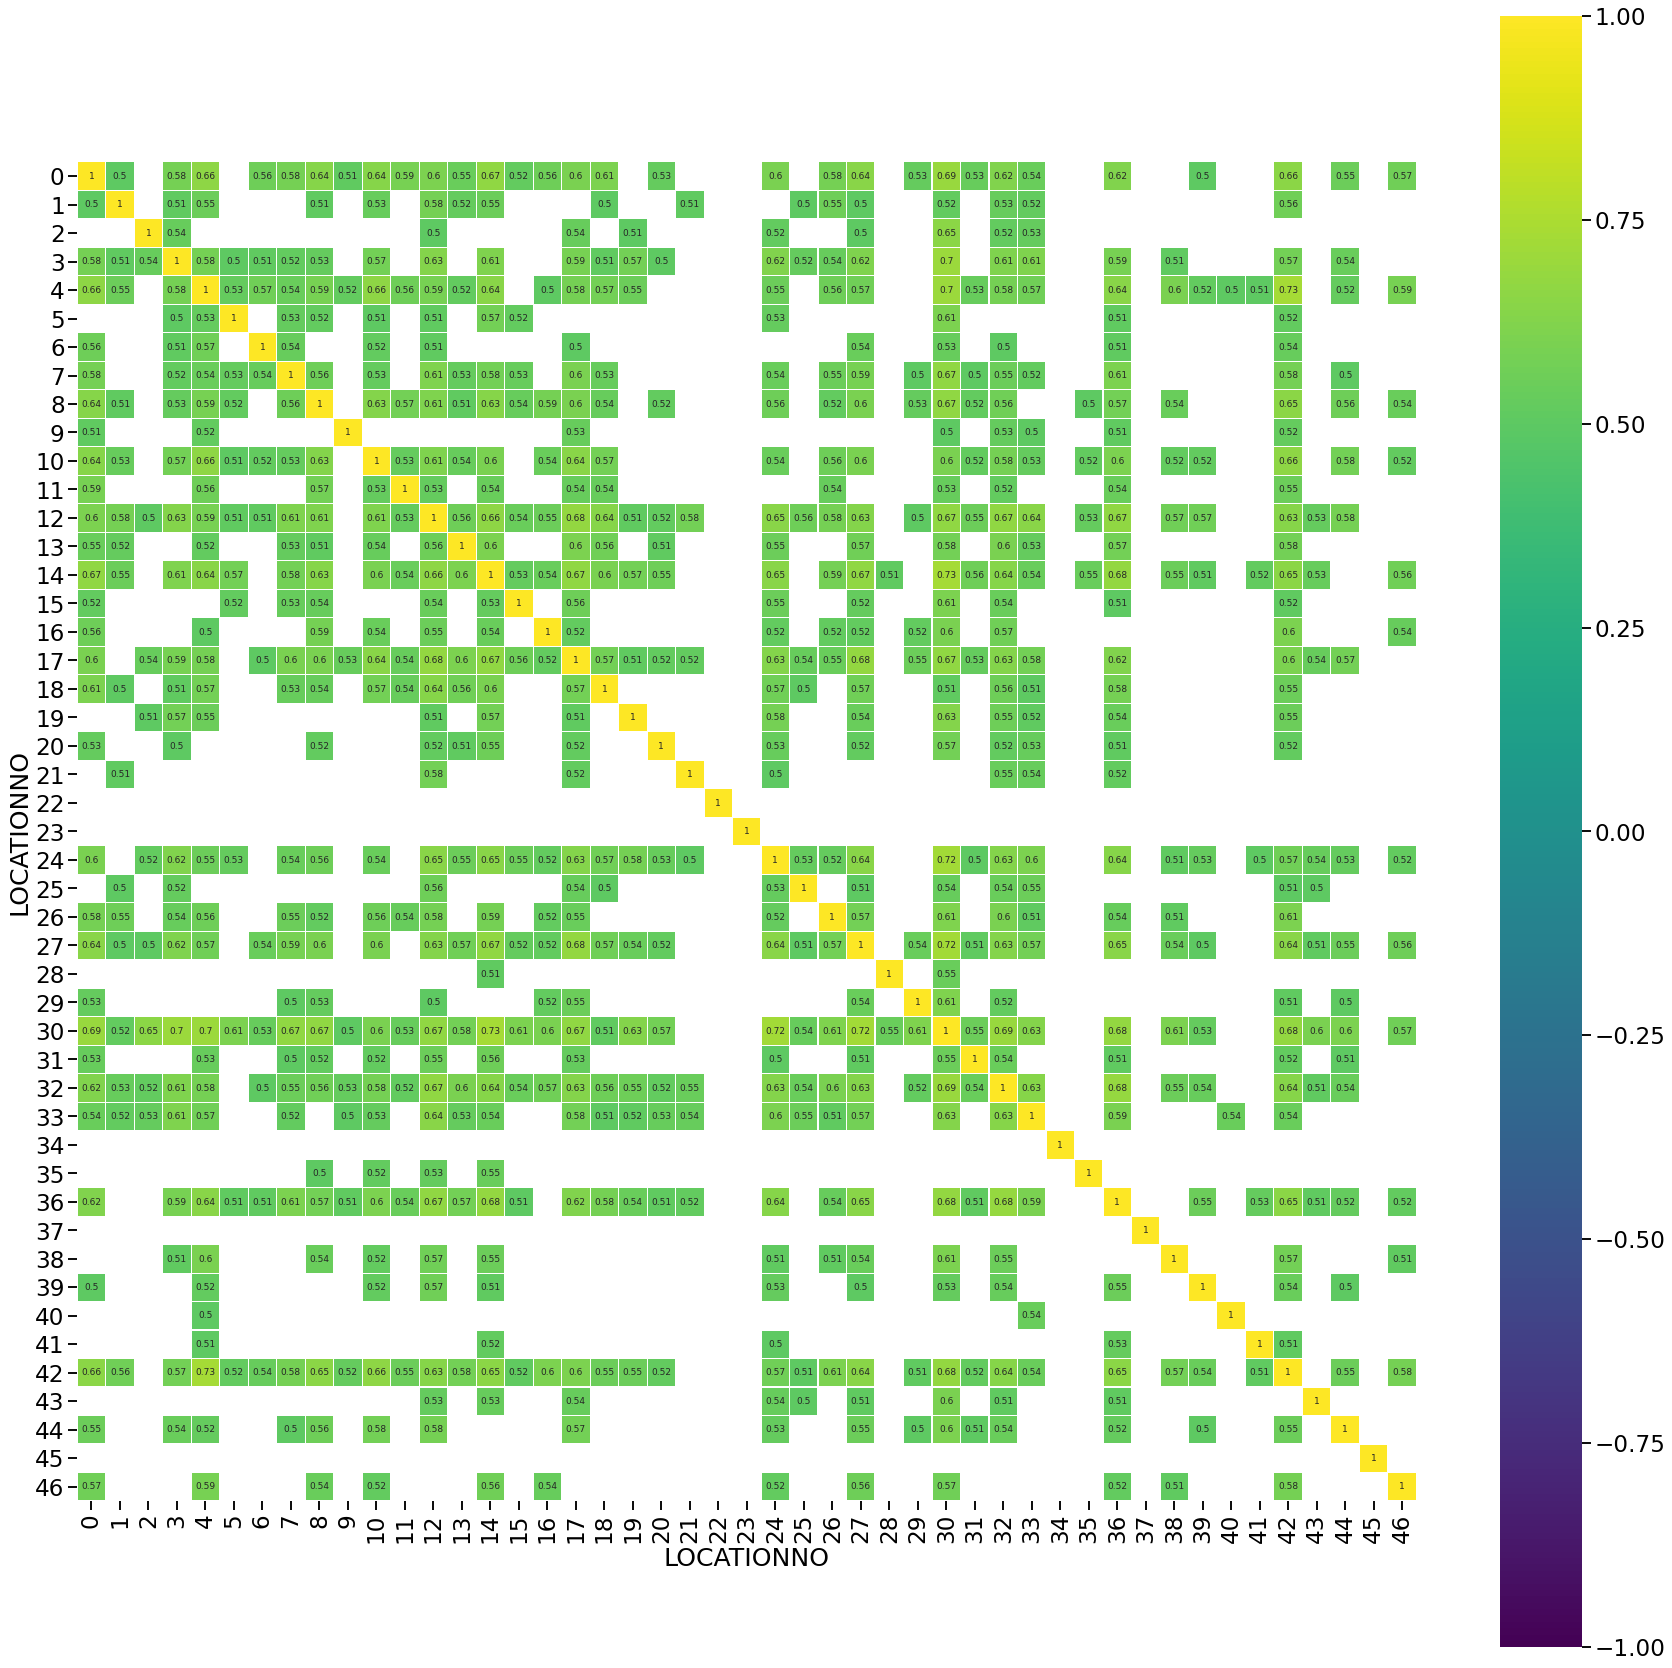

In [15]:
# Correlation between total sales of stores

storesales = sales.groupby(["SALEDATE", "LOCATIONNO"]).UNIT_GROSS_SALES.sum().reset_index().set_index("SALEDATE")
corr =  pd.pivot_table(storesales, values = "UNIT_GROSS_SALES", columns="LOCATIONNO", index="SALEDATE").corr(method = "spearman")
plt.figure(figsize = (30,30))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

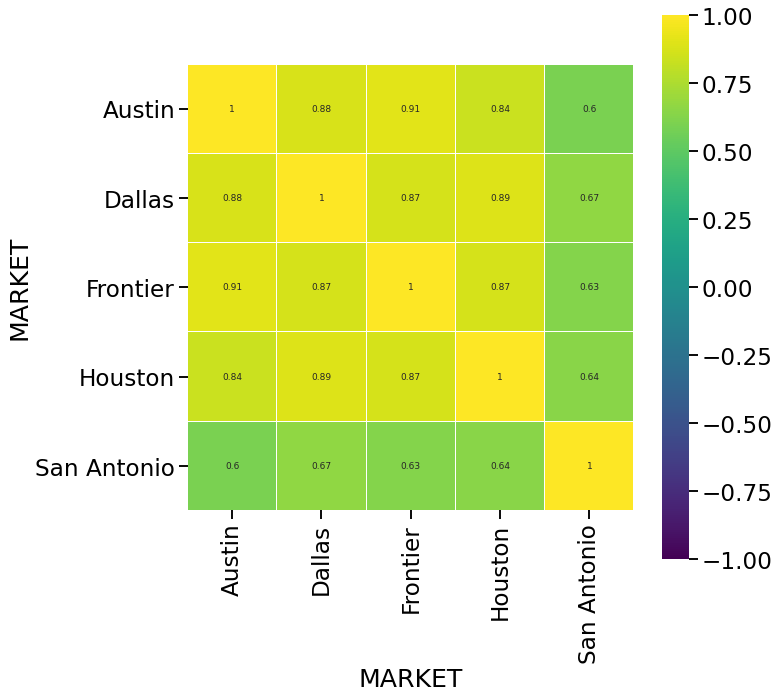

In [16]:
# Correlation between total sales at market level

sns.set_context("talk", font_scale=1.4)
marketsales = sales.groupby(["SALEDATE", "MARKET"]).UNIT_GROSS_SALES.sum().reset_index().set_index("SALEDATE")
corr =  pd.pivot_table(marketsales, values = "UNIT_GROSS_SALES", columns="MARKET", index="SALEDATE").corr(method = "spearman")
plt.figure(figsize = (10,10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

A non-parametric T-test is conducted to see which store sales are similar to each other. The same test is carried out for different items and different markets. This is incorporated during the feaure engineering phase of the project.

In [26]:
# T Test
def CompareTwoGroups(dataframe, group, target):
    
    import itertools
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # 1. Normality Test: Shapiro Test
    # 2. Homogeneity Test: Levene Test
    # 3. Parametric or Non-Parametric T Test: T-Test, Welch Test, Mann Whitney U
    
    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    
    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        
        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True
        
        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1] 
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True
            
        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05], 
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], "GroupB_Count":[groupB.count()]
                            }, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", "p-value","GroupA_Median", "GroupB_Median","GroupA_Mean", "GroupB_Mean",
                                 "GroupA_Count", "GroupB_Count"]]])
        
    return AB
    
    
ctg_store = CompareTwoGroups(storesales, group = "LOCATIONNO", target = "UNIT_GROSS_SALES")
ctg_ss = ctg_store[ctg_store["Compare Two Groups"] == "Similar Groups"]
ctg_ss

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(0, 2)",Non-Parametric,Similar Groups,0.233386,31.0,32.0,38.950052,33.354325,576,548
"(20, 29)",Non-Parametric,Similar Groups,0.337784,15.0,15.0,17.650435,17.266826,575,545
"(20, 36)",Non-Parametric,Similar Groups,0.115768,15.0,15.0,17.650435,21.573333,575,525
"(20, 10)",Non-Parametric,Similar Groups,0.472980,15.0,15.0,17.650435,18.136613,575,437
"(31, 35)",Non-Parametric,Similar Groups,0.380683,14.0,14.0,15.453752,15.801245,573,522
"(31, 43)",Non-Parametric,Similar Groups,0.310684,14.0,13.0,15.453752,14.912548,573,526
"(31, 46)",Non-Parametric,Similar Groups,0.401160,14.0,13.0,15.453752,15.316406,573,512
"(31, 9)",Non-Parametric,Similar Groups,0.361584,14.0,14.0,15.453752,14.959368,573,443
"(32, 17)",Non-Parametric,Similar Groups,0.278548,27.5,27.0,30.599913,30.956124,574,547
"(32, 24)",Non-Parametric,Similar Groups,0.281458,27.5,27.0,30.599913,31.649635,574,548


In [27]:
itemsales = sales.groupby(["SALEDATE", "PRODUCTID"]).UNIT_GROSS_SALES.sum().reset_index().set_index("SALEDATE")
ctg_is = CompareTwoGroups(itemsales, group = "PRODUCTID", target = "UNIT_GROSS_SALES")
ctg_iss = ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]
ctg_iss

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(6, 22)",Non-Parametric,Similar Groups,0.431454,48.0,46.0,47.590106,49.274576,283,295
"(6, 25)",Non-Parametric,Similar Groups,0.062028,48.0,46.0,47.590106,46.115538,283,251
"(6, 28)",Non-Parametric,Similar Groups,0.191243,48.0,51.0,47.590106,49.776119,283,201
"(6, 18)",Non-Parametric,Similar Groups,0.395740,48.0,47.0,47.590106,47.981132,283,106
"(6, 39)",Non-Parametric,Similar Groups,0.282581,48.0,55.0,47.590106,50.518519,283,189
"(6, 44)",Non-Parametric,Similar Groups,0.279319,48.0,57.0,47.590106,52.537234,283,188
"(6, 45)",Non-Parametric,Similar Groups,0.437603,48.0,51.0,47.590106,47.005319,283,188
"(7, 32)",Non-Parametric,Similar Groups,0.267717,24.5,20.0,25.581081,26.617021,222,94
"(7, 0)",Non-Parametric,Similar Groups,0.110582,24.5,27.0,25.581081,26.589286,222,56
"(7, 10)",Non-Parametric,Similar Groups,0.385214,24.5,26.0,25.581081,23.926471,222,68


In [28]:
CompareTwoGroups(marketsales, group = "MARKET", target = "UNIT_GROSS_SALES")

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(Austin, Dallas)",Non-Parametric,Different Groups,2.142448e-28,223.5,315.0,261.493785,345.159545,576,549
"(Austin, Houston)",Non-Parametric,Similar Groups,4.293589e-01,223.5,216.0,261.493785,244.136837,576,528
"(Austin, San Antonio)",Non-Parametric,Different Groups,5.611602e-173,223.5,41.0,261.493785,43.897021,576,527
"(Austin, Frontier)",Non-Parametric,Different Groups,2.915368e-02,223.5,232.5,261.493785,263.604324,576,444
"(Dallas, Houston)",Non-Parametric,Different Groups,4.189280e-39,315.0,216.0,345.159545,244.136837,549,528
"(Dallas, San Antonio)",Non-Parametric,Different Groups,3.759319e-172,315.0,41.0,345.159545,43.897021,549,527
"(Dallas, Frontier)",Non-Parametric,Different Groups,1.311596e-22,315.0,232.5,345.159545,263.604324,549,444
"(Houston, San Antonio)",Non-Parametric,Different Groups,1.266149e-165,216.0,41.0,244.136837,43.897021,528,527
"(Houston, Frontier)",Non-Parametric,Different Groups,1.424168e-02,216.0,232.5,244.136837,263.604324,528,444
"(San Antonio, Frontier)",Non-Parametric,Different Groups,2.881501e-153,41.0,232.5,43.897021,263.604324,527,444


# Feature Engineering

Following features are engineered to be incorporated into the model for better prediction accuracy.

* Time Related Features
    - Year
    - Month
    - Week
    - Day
    - Weekday
    - Day of the year
    - Day of the week
    - Holidays for the state of Texas
    - Is the saledate a weekend?
    - Is the saledate month end?
    - Is the saledate month start?
    - Is the saledate quarter end?
    - Is the saledate quarter start?
    - Is the saledate year end?
    - Is the saledate year start?
* Lagged Features
     - sales lag for 3 days 	
     - sales lag for 7 days
     - sales lag for 14 days 	
     - sales lag for 30 days 	
     - sales lag for 60 days	
     - sales lag for 90 days
* Moving Average Features
     - Rolling mean
* Hypothesis Testing: Similarity Features
     - Similar store sales
     - Similar item sales
     - Similar market sales
* Exponentially Weighted Mean Features

In [29]:
# 1. Time Related Features
#####################################################
def add_datepart(df, clmn):
    df['Year'] = df[clmn].dt.year
    df['Month'] = df[clmn].dt.month
    df['Week'] = df[clmn].dt.isocalendar().week
    df['Day'] = df[clmn].dt.day
    
    wkday = []
    doty = []
    for dt in df[clmn]:
        wkday.append(dt.weekday())
        doty.append(dt.timetuple().tm_yday)
    df['DayofWeek'] = wkday
    df['DayofYear'] = doty
    
    tx = holidays.US(state = 'TX')
    is_holiday = []
    for i in df[clmn]: 
           is_holiday.append(i in tx)
            
    df['Is_holiday'] = is_holiday
    df['Is_holiday'] = df['Is_holiday'].astype(int)
    df['Is_wknd'] = df['DayofWeek'] // 4
    df['Is_month_end'] = df[clmn].dt.is_month_end.astype(int)
    df['Is_month_start'] = df[clmn].dt.is_month_start.astype(int)
    df['Is_quarter_end'] = df[clmn].dt.is_quarter_end.astype(int)
    df['Is_quarter_start'] = df[clmn].dt.is_quarter_start.astype(int)
    df['Is_year_end'] = df[clmn].dt.is_year_end.astype(int)
    df['Is_year_start'] = df[clmn].dt.is_year_start.astype(int)
#     df.drop([clmn], axis = 1, inplace = True)
    return df

new_sales = add_datepart(sales, 'SALEDATE').copy()

In [30]:
# Rolling Summary Stats Features
#####################################################
for i in [4, 7, 14, 30, 60, 100]:
    new_sales["sales_roll_mean_"+str(i)] = new_sales.groupby(["LOCATIONNO", "PRODUCTID"]).UNIT_GROSS_SALES.rolling(i).mean().shift(1).values

In [31]:
# List of similar store sales and similar item sales from the non-parametric t-test.

sim_store = list(ctg_ss.index)
sim_item = list(ctg_iss.index)

In [32]:
# 2. Hypothesis Testing: Similarity
#####################################################

# Store Based
j = 1
for i in sim_store:
    if j == 1:
        new_sales["StoreSalesSimilarity"] = np.where(new_sales.LOCATIONNO.isin(list(i)), j, 0)
    else:
        new_sales["StoreSalesSimilarity"] = np.where(new_sales.LOCATIONNO.isin(list(i)), j, new_sales["StoreSalesSimilarity"])
    j+=1

# item Based
j = 1
for i in sim_item:
    if j == 1:
        new_sales["ItemSalesSimilarity"] = np.where(new_sales.PRODUCTID.isin(list(i)), j, 0)
    else:
        new_sales["ItemSalesSimilarity"] = np.where(new_sales.PRODUCTID.isin(list(i)), j, new_sales["ItemSalesSimilarity"])
    j+=1

# Market Based
new_sales["MarketSalesSimilarity"] = np.where(new_sales.MARKET.isin(['Austin', 'Houston']), 1, 0)


In [33]:
# 3. Lag/Shifted Features
#####################################################

new_sales.sort_values(by=['LOCATIONNO', 'PRODUCTID', 'SALEDATE'], axis=0, inplace=True)

def lag_features(dataframe, lags, groups = ['LOCATIONNO', 'PRODUCTID'], target = 'UNIT_GROSS_SALES', prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe
lag_sales = lag_features(new_sales, lags = [3, 7, 14, 30, 60, 90], 
                         groups = ['LOCATIONNO', 'PRODUCTID'], 
                         target = 'UNIT_GROSS_SALES', prefix = 'sales_lag_').copy()

In [34]:
lag_sales.head()

,LOCATIONNO,MARKET,SALEDATE,PRODUCTID,UNIT_GROSS_SALES,Cost,Year,Month,Week,Day,DayofWeek,DayofYear,Is_holiday,Is_wknd,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales_roll_mean_4,sales_roll_mean_7,sales_roll_mean_14,sales_roll_mean_30,sales_roll_mean_60,sales_roll_mean_100,StoreSalesSimilarity,ItemSalesSimilarity,MarketSalesSimilarity,sales_lag_3,sales_lag_7,sales_lag_14,sales_lag_30,sales_lag_60,sales_lag_90
88361,0,Austin,2020-03-24,0,1.0,1.91,2020,3,13,24,1,84,0,0,0,0,0,0,0,0,1.0,1.428571,1.285714,NaN,NaN,NaN,1,86,1,NaN,NaN,NaN,NaN,NaN,NaN
88948,0,Austin,2020-03-25,0,3.0,1.91,2020,3,13,25,2,85,0,0,0,0,0,0,0,0,1.0,1.000000,1.285714,0.733333,1.133333,1.35,1,86,1,NaN,NaN,NaN,NaN,NaN,NaN
89312,0,Austin,2020-03-26,0,3.0,1.91,2020,3,13,26,3,86,0,0,0,0,0,0,0,0,2.0,1.714286,1.500000,1.766667,1.950000,NaN,1,86,1,NaN,NaN,NaN,NaN,NaN,NaN
89530,0,Austin,2020-03-27,0,1.0,1.91,2020,3,13,27,4,87,0,1,0,0,0,0,0,0,1.0,0.571429,1.071429,1.233333,1.250000,1.63,1,86,1,1.0,NaN,NaN,NaN,NaN,NaN
89919,0,Austin,2020-03-28,0,1.0,1.91,2020,3,13,28,5,88,0,1,0,0,0,0,0,0,1.5,1.714286,1.571429,1.833333,NaN,NaN,1,86,1,3.0,NaN,NaN,NaN,NaN,NaN


Remove correlated features from the dataset

In [35]:
def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+["UNIT_GROSS_SALES"]].corr().UNIT_GROSS_SALES.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(lag_sales, "sales_lag", 5)

In [36]:
lag_sales.head()

,LOCATIONNO,MARKET,SALEDATE,PRODUCTID,UNIT_GROSS_SALES,Cost,Year,Month,Week,Day,DayofWeek,DayofYear,Is_holiday,Is_wknd,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales_roll_mean_4,sales_roll_mean_7,sales_roll_mean_14,sales_roll_mean_30,sales_roll_mean_60,sales_roll_mean_100,StoreSalesSimilarity,ItemSalesSimilarity,MarketSalesSimilarity,sales_lag_3,sales_lag_7,sales_lag_14,sales_lag_30
88361,0,Austin,2020-03-24,0,1.0,1.91,2020,3,13,24,1,84,0,0,0,0,0,0,0,0,1.0,1.428571,1.285714,NaN,NaN,NaN,1,86,1,NaN,NaN,NaN,NaN
88948,0,Austin,2020-03-25,0,3.0,1.91,2020,3,13,25,2,85,0,0,0,0,0,0,0,0,1.0,1.000000,1.285714,0.733333,1.133333,1.35,1,86,1,NaN,NaN,NaN,NaN
89312,0,Austin,2020-03-26,0,3.0,1.91,2020,3,13,26,3,86,0,0,0,0,0,0,0,0,2.0,1.714286,1.500000,1.766667,1.950000,NaN,1,86,1,NaN,NaN,NaN,NaN
89530,0,Austin,2020-03-27,0,1.0,1.91,2020,3,13,27,4,87,0,1,0,0,0,0,0,0,1.0,0.571429,1.071429,1.233333,1.250000,1.63,1,86,1,1.0,NaN,NaN,NaN
89919,0,Austin,2020-03-28,0,1.0,1.91,2020,3,13,28,5,88,0,1,0,0,0,0,0,0,1.5,1.714286,1.571429,1.833333,NaN,NaN,1,86,1,3.0,NaN,NaN,NaN


In [37]:
# 4. Last i. Months
#####################################################
lag_sales["monthyear"] = lag_sales.SALEDATE.dt.to_period('M')

# Store-Item Based
for i in [3, 6, 9, 12, 15]:
    last_months = lag_sales.groupby(["LOCATIONNO", "PRODUCTID", "monthyear"]).UNIT_GROSS_SALES.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['LOCATIONNO', 'PRODUCTID', 'monthyear', 'last_'+str(i)+'months_sales_sum',
                           'last_'+str(i)+'months_sales_mean', 'last_'+str(i)+'months_sales_std',
                           'last_'+str(i)+'months_sales_min', 'last_'+str(i)+'months_sales_max']
    lag_sales = pd.merge(lag_sales, last_months, how   = "left", on = ["LOCATIONNO", "PRODUCTID", "monthyear"])
del last_months, i

drop_cor(lag_sales, "last_", 4)

# Store Based


for i in [3, 6, 9, 12]:
    last_months = lag_sales.groupby(["LOCATIONNO", "monthyear"]).UNIT_GROSS_SALES.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['LOCATIONNO', 'monthyear', 'store_last_'+str(i)+'months_sales_sum',
                           'store_last_'+str(i)+'months_sales_mean', 'store_last_'+str(i)+'months_sales_std',
                           'store_last_'+str(i)+'months_sales_min', 'store_last_'+str(i)+'months_sales_max']
    lag_sales = pd.merge(lag_sales, last_months, how = "left", on = ["LOCATIONNO", "monthyear"])
del last_months, i


# Item Based
for i in [3, 6, 9, 12]:
    last_months = lag_sales.groupby(["PRODUCTID", "monthyear"]).UNIT_GROSS_SALES.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['PRODUCTID', 'monthyear', 'item_last_'+str(i)+'months_sales_sum',
                           'item_last_'+str(i)+'months_sales_mean', 'item_last_'+str(i)+'months_sales_std',
                           'item_last_'+str(i)+'months_sales_min', 'item_last_'+str(i)+'months_sales_max']
    lag_sales = pd.merge(lag_sales, last_months, how = "left", on = ["PRODUCTID", "monthyear"])
del last_months, i


# Similarity Based


for i in [3, 6, 9, 12]:
    last_months = lag_sales.groupby(["StoreSalesSimilarity", "monthyear"]).UNIT_GROSS_SALES.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['StoreSalesSimilarity', 'monthyear', 'storesim_last_'+str(i)+'months_sales_sum',
                           'storesim_last_'+str(i)+'months_sales_mean', 'storesim_last_'+str(i)+'months_sales_std',
                           'storesim_last_'+str(i)+'months_sales_min', 'storesim_last_'+str(i)+'months_sales_max']
    lag_sales = pd.merge(lag_sales, last_months, how = "left", on = ["StoreSalesSimilarity", "monthyear"])
del last_months, i

for i in [3, 6, 9, 12]:
    last_months = lag_sales.groupby(["ItemSalesSimilarity", "monthyear"]).UNIT_GROSS_SALES.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['ItemSalesSimilarity', 'monthyear', 'itemsim_last_'+str(i)+'months_sales_sum',
                           'itemsim_last_'+str(i)+'months_sales_mean', 'itemsim_last_'+str(i)+'months_sales_std',
                           'itemsim_last_'+str(i)+'months_sales_min', 'itemsim_last_'+str(i)+'months_sales_max']
    lag_sales = pd.merge(lag_sales, last_months, how = "left", on = ["ItemSalesSimilarity", "monthyear"])
del last_months, i

lag_sales.drop("monthyear", axis = 1, inplace = True)

In [38]:
# 5. Last i. day of week
#####################################################
lag_sales.sort_values(["LOCATIONNO", "PRODUCTID", "DayofWeek", "SALEDATE"], inplace = True)

lag_sales = lag_features(lag_sales, lags = np.arange(12,41, 1).tolist()+[3, 7, 60, 90],
                  groups = ["LOCATIONNO", "PRODUCTID", "DayofWeek"], target = 'UNIT_GROSS_SALES', prefix = 'dayofweek_sales_lag_')

lag_sales[lag_sales.columns[lag_sales.columns.str.contains("dayofweek_sales_lag_")].tolist()+["UNIT_GROSS_SALES"]].corr().UNIT_GROSS_SALES.sort_values(ascending = False)

drop_cor(lag_sales, "dayofweek_sales_lag_", 5)

lag_sales.sort_values(["LOCATIONNO", "PRODUCTID", "SALEDATE"], inplace = True)


In [39]:
#####################################################
# Exponentially Weighted Mean Features
#####################################################
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["LOCATIONNO", "PRODUCTID"])['UNIT_GROSS_SALES']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [3, 7, 14, 30, 60, 90]

df = ewm_features(lag_sales, alphas, lags).copy()

df.shape

(290014, 150)

# Train-Validation Split

In [40]:
# Dataframe must be sorted by date because of Time Series Split
df = df.sort_values("SALEDATE").reset_index(drop = True)
df['Week'] = df['Week'].astype(int)
df = pd.get_dummies(df, columns = ['MARKET'])

# Train Validation Split
# Validation set includes 2 months (Jan, Feb)
train = df.loc[(df["SALEDATE"] < "2021-01-01"), :]
val = df.loc[(df["SALEDATE"] >= "2021-01-01") & (df["SALEDATE"] < "2021-03-01"), :]
test = df.loc[(df["SALEDATE"] >= "2021-03-01")] # Any data after Feb 28 is set aside as test set.

cols = [col for col in train.columns if col not in ['SALEDATE', "UNIT_GROSS_SALES", "Year"]]

Y_train = train['UNIT_GROSS_SALES']
X_train = train[cols]

Y_val = val['UNIT_GROSS_SALES']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((217822,), (217822, 151), (44368,), (44368, 151))

# Custom Cost Function

Symmetric mean absolute percentage error is used as the cost function 

SMAPE = $\frac{100\%}{n}\sum_{t=1}^{n}\frac{|F_t - A_t|}{(|A_t| + |F_t|)/2}$

where $A_t$ is the actual value and $F_t$ is the forecast value. The absolute difference between $A_t$ and $F_t$ is divided by half the sum of absolute values of the actual value $A_t$ and the forecast value $F_t$. The value of this calculation is summed for every fitted point t and divided again by the number of fitted points n. 

In [41]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

# First Model


After completing the feature engineering phase the first model with default parameters and all the features is built and it's performance is analysed. The model considered here is the lgbm model for its 

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency
* Lower memory usage
* Better accuracy
* Capability to handle large-scale data.

In [42]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 69.37855260588468
VALID SMAPE: 96.27532578267159


# Feature Importance

In [44]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    
    
    # LGBM API
    #gain = model.feature_importance('gain')
    #feat_imp = pd.DataFrame({'feature': model.feature_name(),
    #                         'split': model.feature_importance('split'),
    #                         'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set_context("talk", font_scale=1)
        sns.set_style("whitegrid")
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25], color = 'lightblue')
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=10)

                           feature  split       gain
141       sales_ewm_alpha_05_lag_7     78  31.387042
140       sales_ewm_alpha_05_lag_3    100  22.170319
142      sales_ewm_alpha_05_lag_14     51   9.177836
6                        DayofWeek    267   5.746324
114          dayofweek_sales_lag_3     76   2.918399
7                        DayofYear    190   2.184596
21             sales_roll_mean_100    204   1.659234
20              sales_roll_mean_60    173   1.539139
5                              Day    165   1.366325
43   store_last_9months_sales_mean      7   1.329502


In [45]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((151, 3), (133, 3), (21, 3))

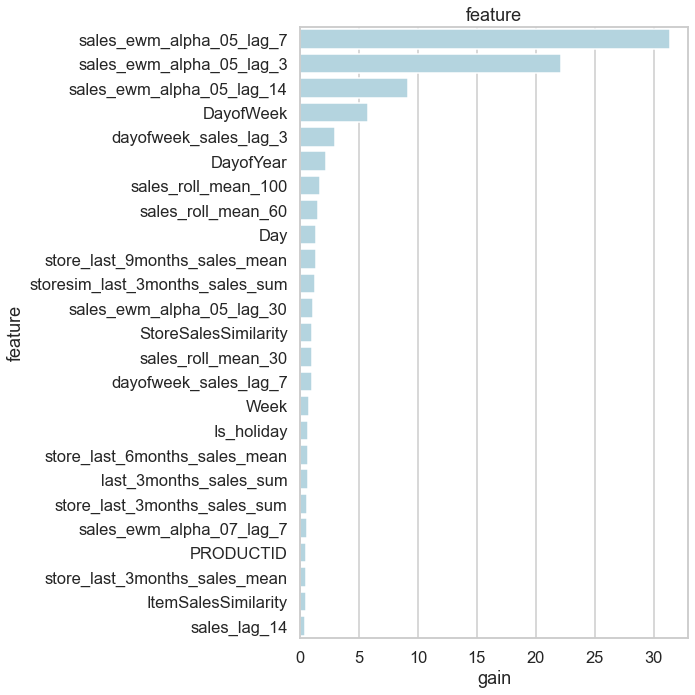

In [46]:
plot_lgb_importances(first_model, plot=True)

# Shap

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [50]:
sns.set_context('talk', font_scale = 1.4)
explainer = shap.Explainer(first_model)
shap_values_train = explainer(X_train)
shap_values_valid = explainer(X_val)

len(shap_values_train), len(shap_values_valid)

(217822, 44368)

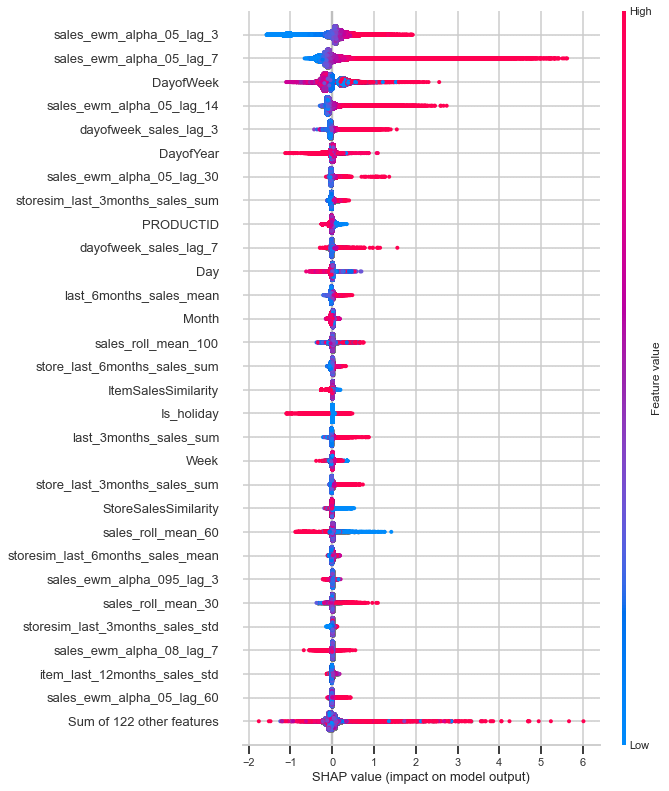

In [51]:
# summarize the effects of all the features
sns.set_context('talk', font_scale = 1.4)
shap.plots.beeswarm(shap_values_train, max_display=30)

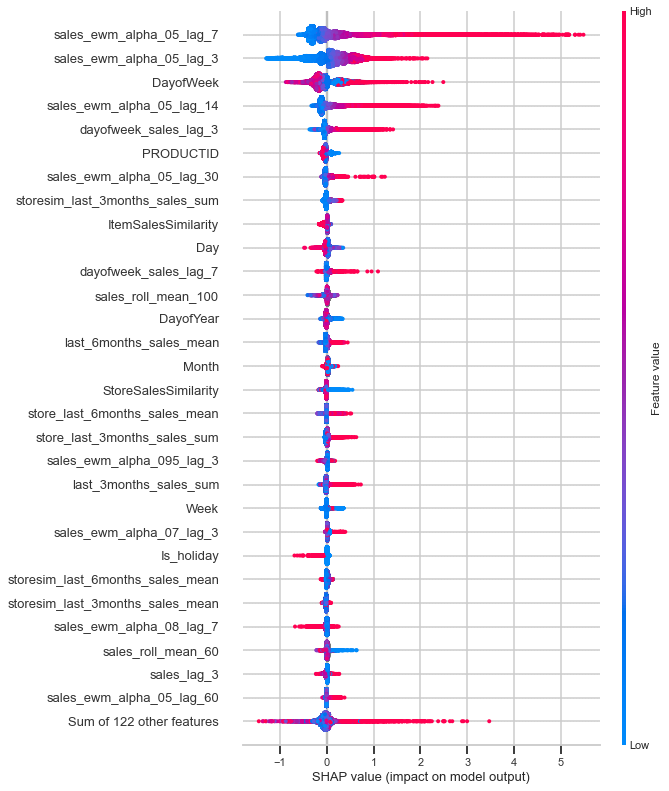

In [52]:
# summarize the effects of all the features
sns.set_context('talk', font_scale = 1.4)
shap.plots.beeswarm(shap_values_valid, max_display=30)

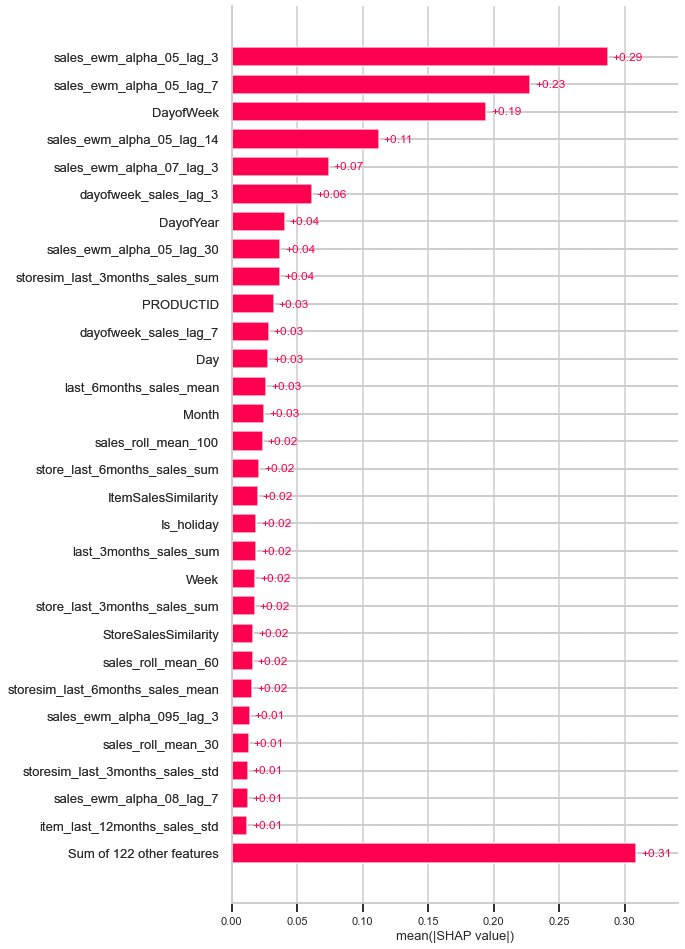

In [53]:
shap.plots.bar(shap_values_train, max_display=30)

# Error Analysis

In [48]:
error = pd.DataFrame({
    "date":val.SALEDATE,
    "store":X_val.LOCATIONNO,
    "item":X_val.PRODUCTID,
    "actual":Y_val,
    "pred":first_model.predict(X_val)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)

error.sort_values("error", ascending=False).head(20)

,date,store,item,actual,pred,error
38403,2021-02-21,30,41,85.0,11.357431,73.642569
38456,2021-02-21,30,37,57.0,9.129747,47.870253
38569,2021-02-21,30,3,59.0,13.590359,45.409641
38439,2021-02-21,4,41,36.0,5.282435,30.717565
18216,2021-01-25,30,42,43.0,13.941786,29.058214
39840,2021-02-22,30,42,38.0,9.921250,28.078750
43925,2021-02-28,30,41,44.0,16.407923,27.592077
14008,2021-01-19,30,42,32.0,8.389453,23.610547
38932,2021-02-21,4,37,31.0,7.826655,23.173345
38563,2021-02-21,30,43,31.0,8.182316,22.817684


In [49]:
error[["actual", "pred", "error"]].describe([0.7, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,50%,70%,80%,90%,95%,99%,max
actual,44368.0,2.584691,3.101834,0.000000,2.000000,3.000000,4.000000,6.000000,8.000000,14.000000,85.000000
pred,44368.0,2.350267,1.485043,0.101703,2.007167,2.537990,2.980707,3.834862,4.929053,8.650099,18.277589
error,44368.0,1.864230,1.917119,0.000021,1.405939,2.089352,2.657121,3.826397,5.232841,9.339638,73.642569


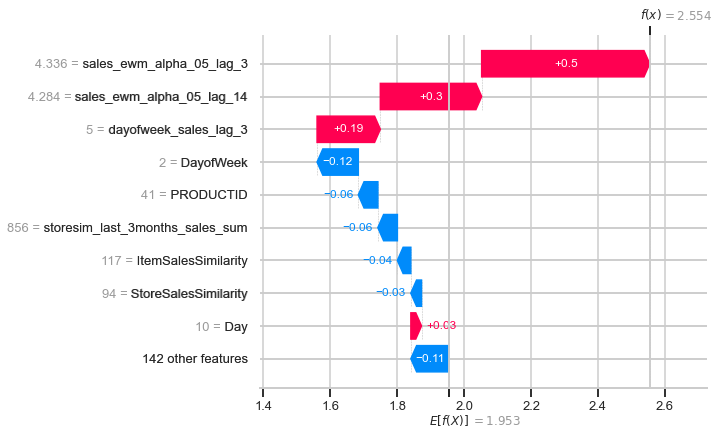

In [54]:
sns.set_context('talk', font_scale = 1.4)
shap.plots.waterfall(shap_values_valid[30125])

In [55]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values_valid[30125])

In [ ]:
# visualize the explanation for the all the prediction with a force plot. So as to not overwhelm the browser
# first 100 values are passed
valid_shap = explainer.shap_values(X_val)
shap.initjs()
shap.plots.force(explainer.expected_value, valid_shap[:100,:], X_val[:100, :])

In [59]:
# Mean Absolute Error
error.groupby(["store", "item"]).error.mean().sort_values(ascending = False)

store  item
30     41      8.796683
       3       7.730369
       27      7.417767
       42      7.331254
       37      6.566694
       1       6.551101
       38      6.450013
       8       5.688377
       34      5.215296
       11      4.847538
       43      4.786728
12     42      4.604071
       3       4.430166
30     13      4.366960
       40      4.349082
0      34      4.321580
       42      4.259871
30     39      4.251495
4      37      4.141325
       8       4.049376
33     3       3.985145
4      42      3.982138
12     8       3.964201
       27      3.933068
0      11      3.931204
       3       3.796247
       1       3.767996
12     34      3.690778
0      27      3.663062
30     44      3.632818
12     41      3.628897
4      3       3.591541
0      8       3.581333
4      41      3.575084
24     1       3.554002
0      41      3.517047
1      3       3.429900
4      38      3.424165
       1       3.372646
       27      3.366829
36     3       3.359900
33  

In [50]:
# Mean Absolute Error
error.groupby(["item"]).error.mean().sort_values(ascending = False)

item
3     2.300384
41    2.237997
42    2.224660
27    2.125854
1     2.119102
8     1.999352
38    1.992689
37    1.982540
34    1.842083
13    1.798909
11    1.722505
43    1.682012
44    1.597961
39    1.484561
40    1.441437
45    1.275640
Name: error, dtype: float64

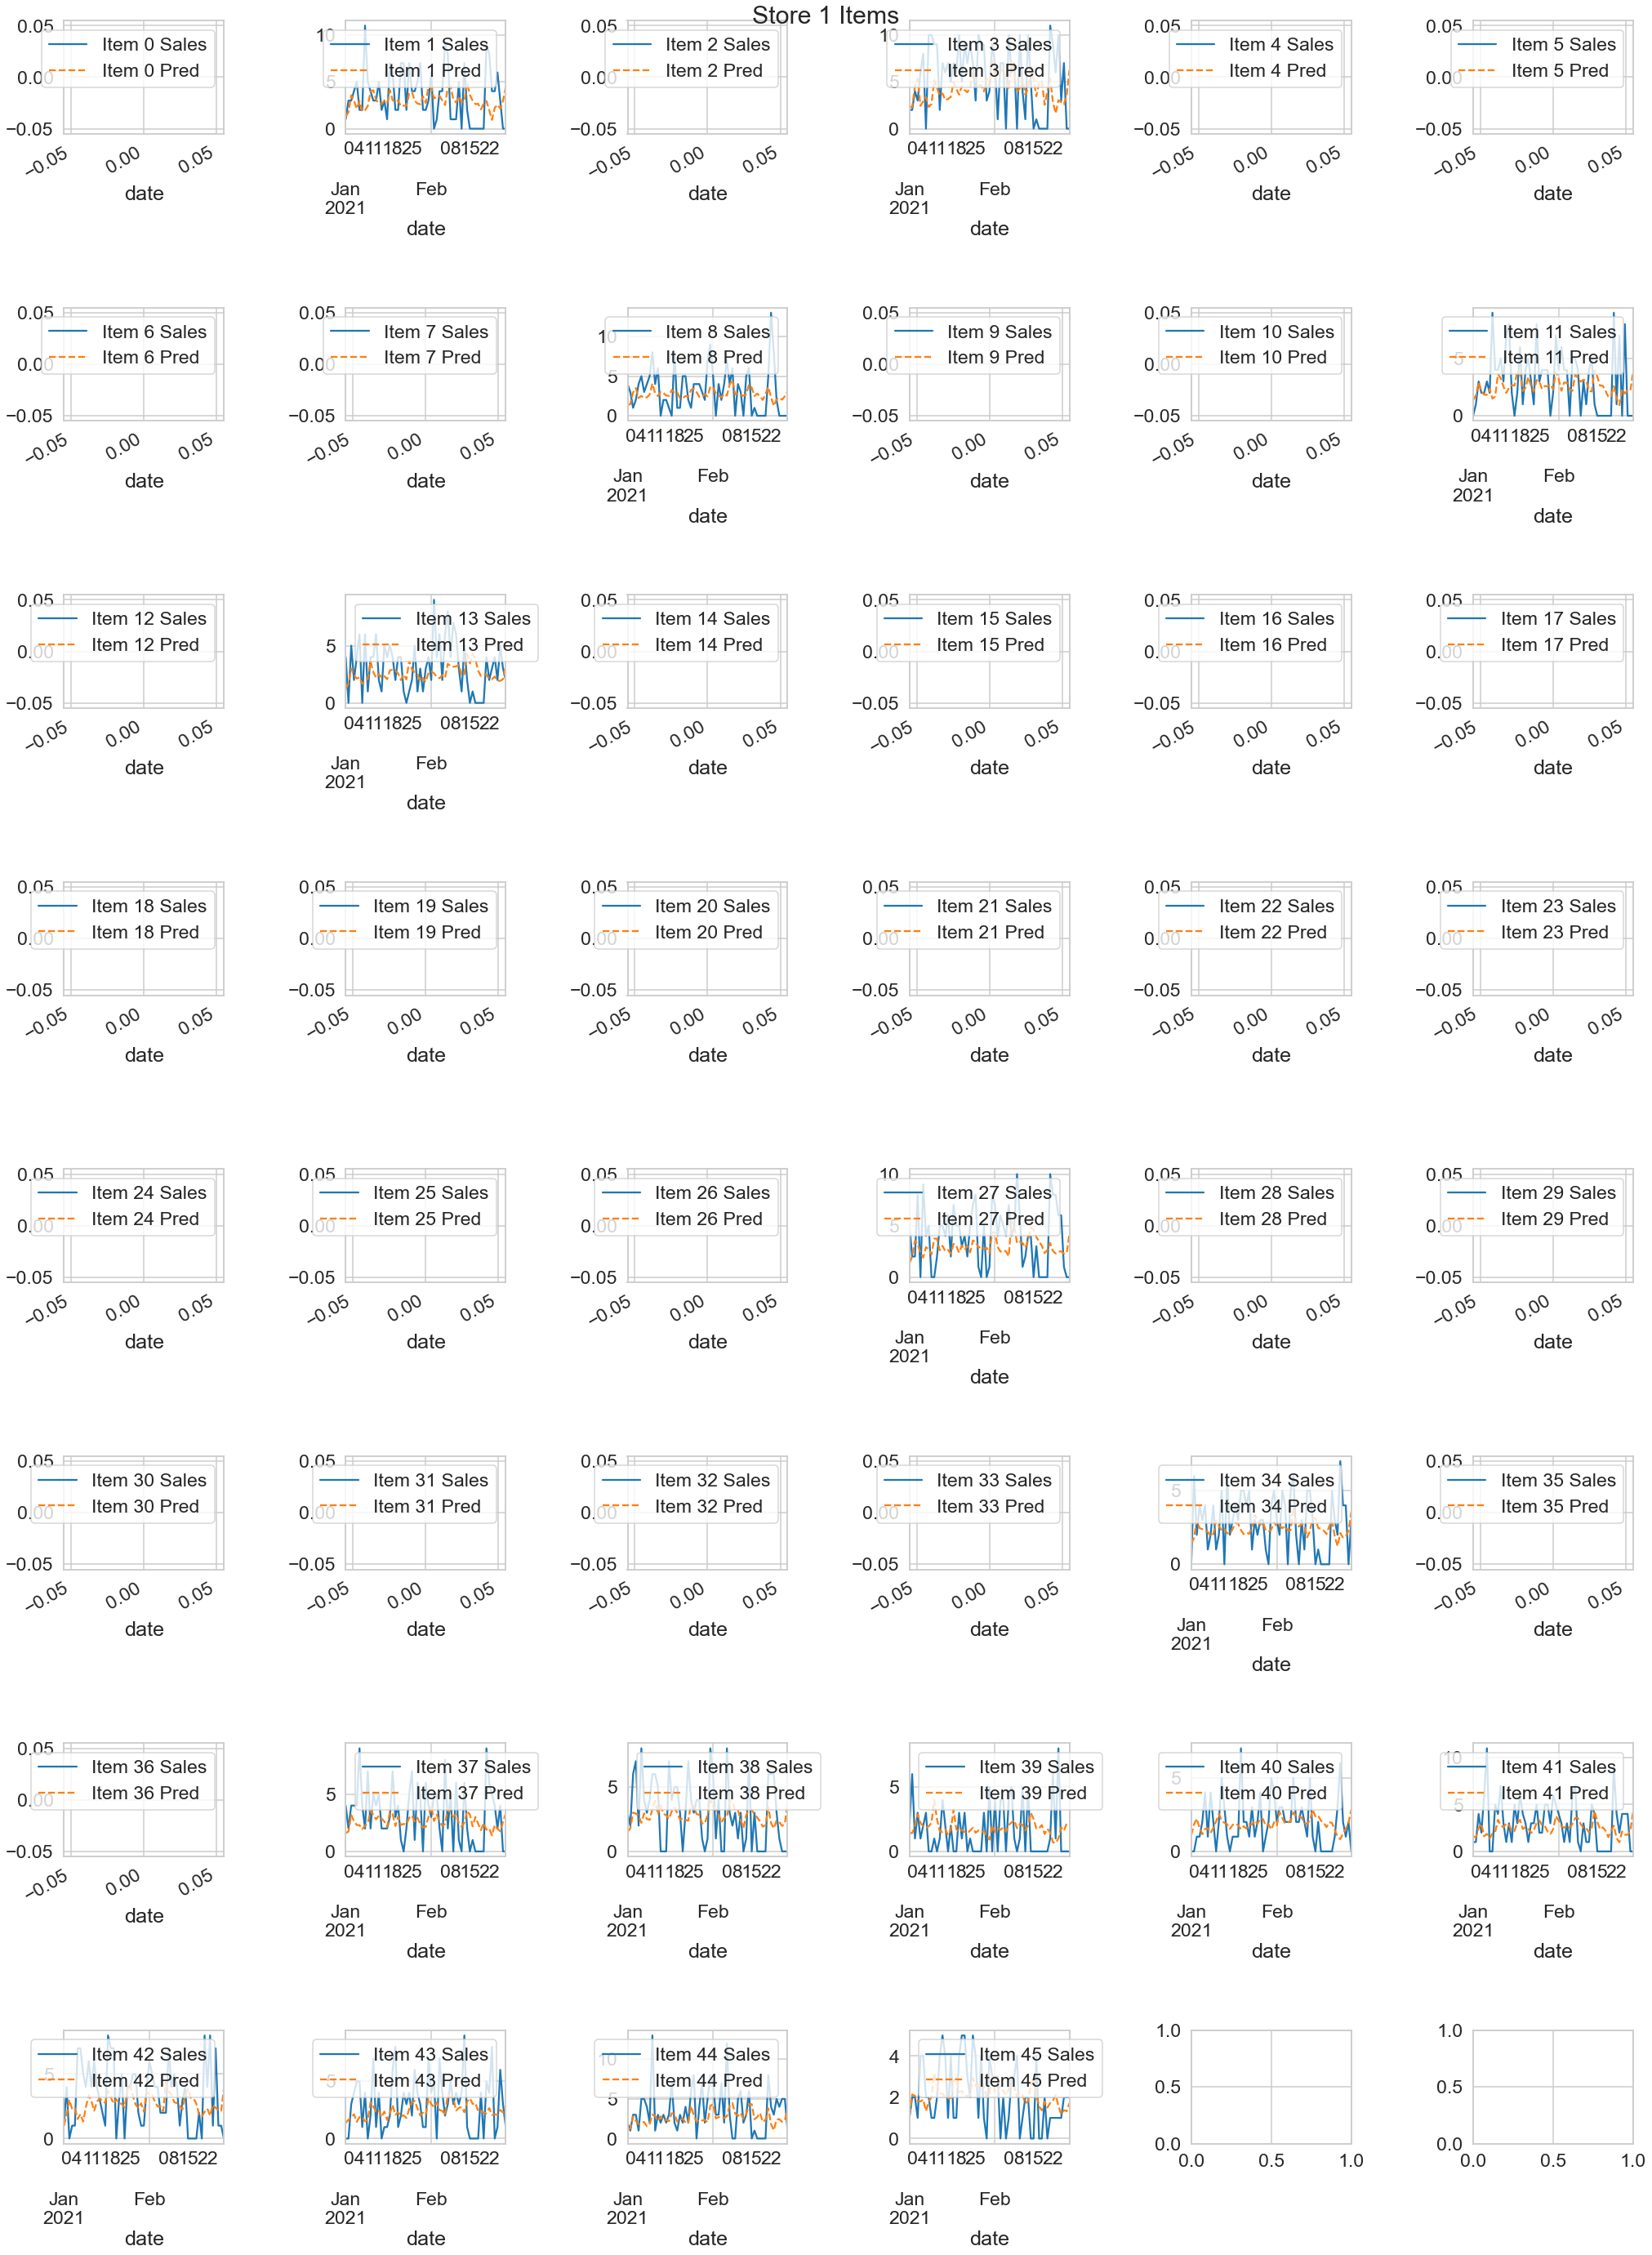

In [51]:
# Store 1 Actual - Pred
sns.set_context("talk", font_scale=1.4)
# fig, axes = plt.subplots(8, 6, figsize=(20, 35))
sub = error[error.store == 1].set_index("date")
fig, axes = plt.subplots(8, 6, figsize=(30, 40))
for i in range(0,46):
    if i < 6:
        sub[sub.item == i].actual.plot(ax=axes[0, i], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[0, i], legend=True, label="Item " + str(i) + " Pred", linestyle = "dashed")
    elif i > 5 and i < 12:
        sub[sub.item == i].actual.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[1, i - 6], legend=True, label="Item " + str(i) + " Pred",  linestyle="dashed")
    elif i > 11 and i< 18:
        sub[sub.item == i].actual.plot(ax=axes[2, i - 12], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[2, i - 12], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    elif i > 17 and i< 24:
        sub[sub.item == i].actual.plot(ax=axes[3, i - 18], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[3, i - 18], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    elif i > 23 and i< 30:
        sub[sub.item == i].actual.plot(ax=axes[4, i - 24], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[4, i - 24], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    elif i > 29 and i< 36:
        sub[sub.item == i].actual.plot(ax=axes[5, i - 30], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[5, i - 30], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    elif i > 35 and i < 42:
        sub[sub.item == i].actual.plot(ax=axes[6, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[6, i - 36], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    else:
        sub[sub.item == i].actual.plot(ax=axes[7, i - 42], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[7, i - 42], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")

plt.tight_layout(pad=3)
plt.suptitle("Store 1 Items");
plt.show()

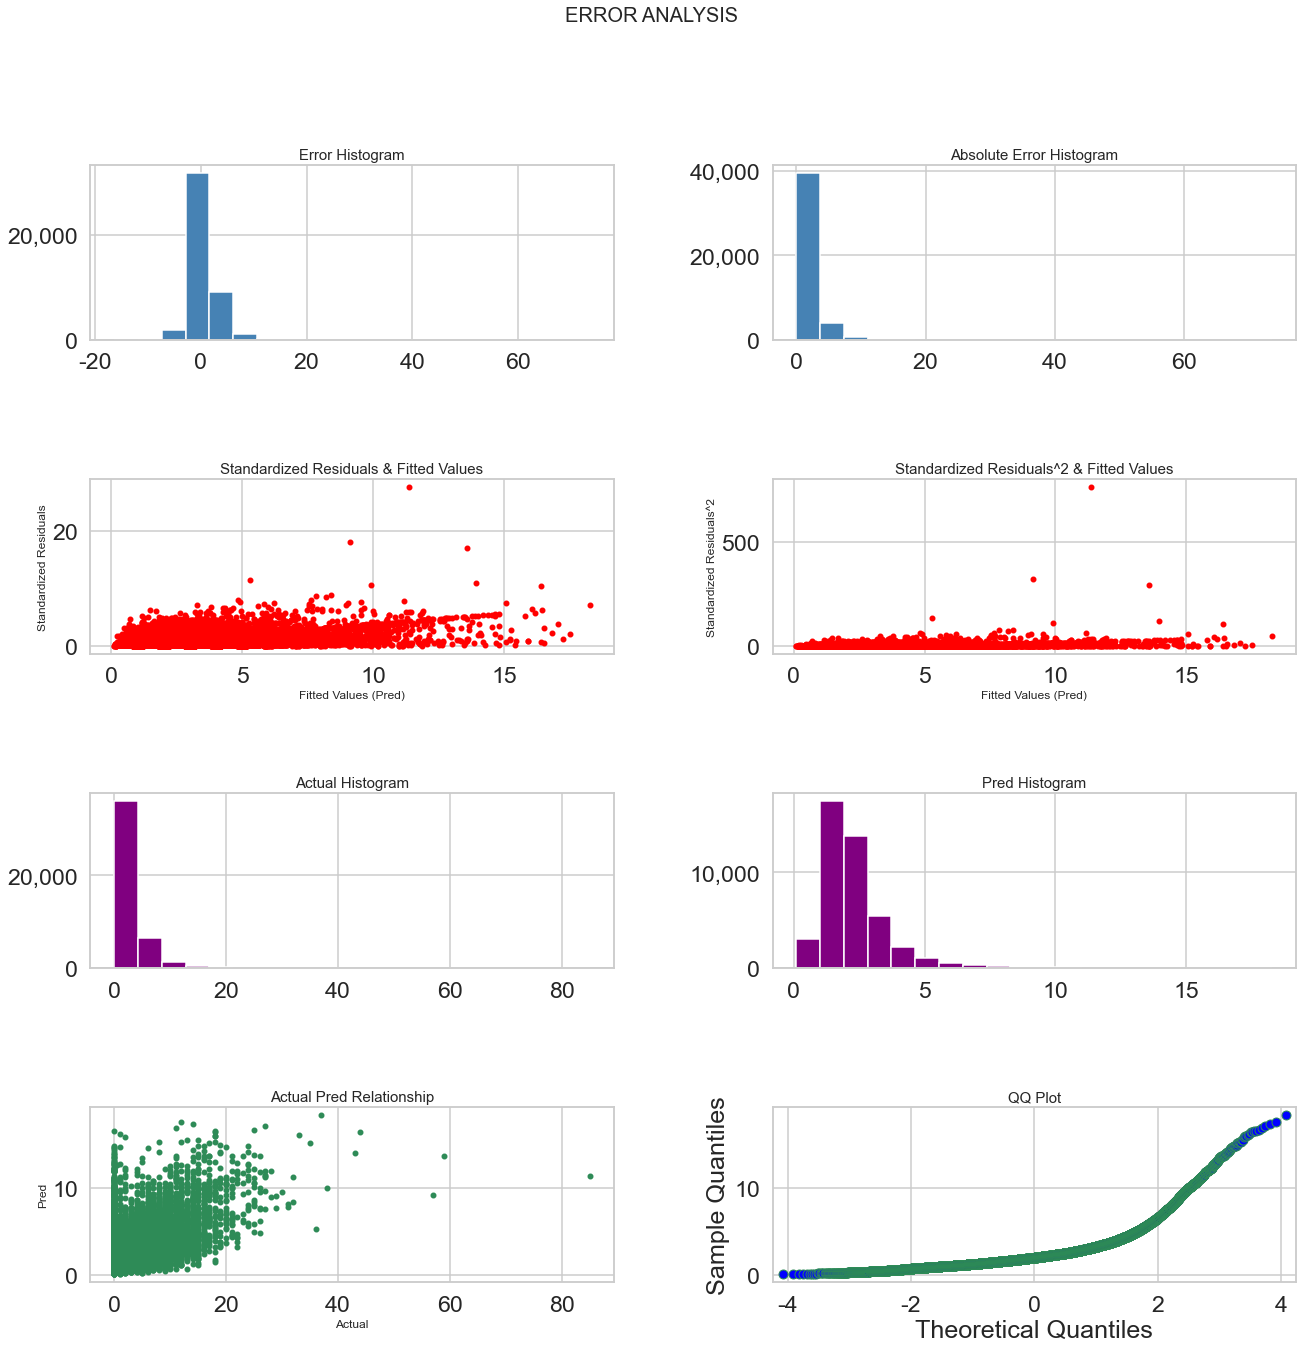

In [52]:
sns.set_context('talk', font_scale = 1.4)
fig, axes = plt.subplots(4, 2, figsize = (20,20))
for axi in axes.flat:
    axi.ticklabel_format(style="sci", axis="y", scilimits=(0,10))
    axi.ticklabel_format(style="sci", axis="x", scilimits=(0,10))
    axi.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    axi.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
(error.actual-error.pred).hist(ax = axes[0, 0], color = "steelblue", bins = 20)
error.error.hist(ax = axes[0,1], color = "steelblue", bins = 20)
sr = error.copy()
sr["StandardizedR"] = (sr.error / (sr.actual-sr.pred).std())
sr["StandardizedR2"] = ((sr.error / (sr.actual-sr.pred).std())**2)
sr.plot.scatter(x = "pred",y = "StandardizedR", color = "red", ax = axes[1,0])
sr.plot.scatter(x = "pred",y = "StandardizedR2", color = "red", ax = axes[1,1])
error.actual.hist(ax = axes[2, 0], color = "purple", bins = 20)
error.pred.hist(ax = axes[2, 1], color = "purple", bins = 20)
error.plot.scatter(x = "actual",y = "pred", color = "seagreen", ax = axes[3,0]);

# QQ Plot
import statsmodels.api as sm
import pylab
sm.qqplot(sr.pred, ax = axes[3,1], c = "seagreen")
plt.suptitle("ERROR ANALYSIS", fontsize = 20)
axes[0,0].set_title("Error Histogram", fontsize = 15)
axes[0,1].set_title("Absolute Error Histogram", fontsize = 15)
axes[1,0].set_title("Standardized Residuals & Fitted Values", fontsize = 15)
axes[1,1].set_title("Standardized Residuals^2 & Fitted Values", fontsize = 15)
axes[2,0].set_title("Actual Histogram", fontsize = 15)
axes[2,1].set_title("Pred Histogram", fontsize = 15);
axes[3,0].set_title("Actual Pred Relationship", fontsize = 15);
axes[3,1].set_title("QQ Plot", fontsize = 15);
axes[1,0].set_xlabel("Fitted Values (Pred)", fontsize = 12)
axes[1,1].set_xlabel("Fitted Values (Pred)", fontsize = 12)
axes[3,0].set_xlabel("Actual", fontsize = 12)
axes[1,0].set_ylabel("Standardized Residuals", fontsize = 12)
axes[1,1].set_ylabel("Standardized Residuals^2", fontsize = 12)
axes[3,0].set_ylabel("Pred", fontsize = 12)
fig.tight_layout(pad=3.0)
plt.savefig("errors.png")
plt.show()

# Next Model

## Default Parameters & Feature Selection with LGBM Feature Importance

In [53]:
# First model feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

second_model = lgb.LGBMRegressor(random_state=384).fit(
    X_train[cols], Y_train, 
    eval_metric = lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

Independent Variables: 117
TRAIN SMAPE: 69.48193950896932
VALID SMAPE: 95.93174397344767


In [54]:
lgbm_params = {

"num_leaves":[20,31], # Default 31
"max_depth":[-1, 20, 30], # Default -1
"learning_rate":[0.1, 0.05], # Default 0.1
"n_estimators":[10000,15000], # Default 100
"min_split_gain":[0.0, 2,5], # Default 0
"min_child_samples":[10, 20, 30], # Default 20
"colsample_bytree":[0.5, 0.8, 1.0], # Default 1
"reg_alpha":[0.0, 0.5, 1], # Default 0
"reg_lambda":[0.0, 0.5, 1] # Default 0

}

model = lgb.LGBMRegressor(random_state=384)

tscv = TimeSeriesSplit(n_splits=3)
rsearch = RandomizedSearchCV(model, lgbm_params, random_state=384, cv=tscv, scoring=make_scorer(smape), verbose = True, n_jobs = -1).fit( X_train[cols], Y_train )

print(rsearch.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 136.3min finished


{'reg_lambda': 0.0, 'reg_alpha': 1, 'num_leaves': 20, 'n_estimators': 10000, 'min_split_gain': 0.0, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [55]:
model_tuned = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384).fit(X_train[cols], Y_train)

print("TRAIN SMAPE:", smape(Y_train, model_tuned.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, model_tuned.predict(X_val[cols])))

TRAIN SMAPE: 48.433166801003026
VALID SMAPE: 97.24837091281393


In [56]:
model_tuned2 = lgb.LGBMRegressor(num_leaves=31, n_estimators=15000, max_depth=20, random_state=384, metric = "custom")      
model_tuned2.fit(
    X_train[cols], Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set = [(X_train[cols], Y_train), (X_val[cols], Y_val)],
    eval_names = ["Train", "Valid"],
    early_stopping_rounds= 1000, verbose = 500
)
print("Best Iteration:", model_tuned2.booster_.best_iteration)

Training until validation scores don't improve for 1000 rounds
[500]	Train's SMAPE: 66.2324	Valid's SMAPE: 95.4403
[1000]	Train's SMAPE: 63.2125	Valid's SMAPE: 95.5624
[1500]	Train's SMAPE: 60.7468	Valid's SMAPE: 95.4656
Early stopping, best iteration is:
[696]	Train's SMAPE: 64.8907	Valid's SMAPE: 95.3564
Best Iteration: 696


In [57]:
df.sort_values(["LOCATIONNO", "PRODUCTID", "SALEDATE"], inplace = True)

train_final = df.loc[(df["SALEDATE"] < "2021-03-01"), :]
test_final = df.loc[(df["SALEDATE"] >= "2021-03-01"), :]

X_train_final = train_final[cols]
Y_train_final = train_final.UNIT_GROSS_SALES
X_test_final = test_final[cols]



final_model = lgb.LGBMRegressor(num_leaves=31, n_estimators=15000, max_depth=20, random_state=384, metric = "custom")
final_model.set_params(n_estimators=model_tuned2.booster_.best_iteration) # Best Iteration: 983
final_model.fit(X_train_final[cols], Y_train_final,
                eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

LGBMRegressor(max_depth=20, metric='custom', n_estimators=696, random_state=384)

In [58]:
final_model.predict(X_test_final)

array([6.82137589, 5.82712452, 3.76803532, ..., 2.00950222, 1.83432827,
       1.17740984])

In [59]:
sales_test = test_final[['LOCATIONNO', 'SALEDATE', 'PRODUCTID', 'UNIT_GROSS_SALES']]
sales_test['Predictions'] = np.round(final_model.predict(X_test_final))
sales_test['error'] = sales_test['UNIT_GROSS_SALES'] - sales_test['Predictions']
sales_test.head()

,LOCATIONNO,SALEDATE,PRODUCTID,UNIT_GROSS_SALES,Predictions,error
262726,0,2021-03-01,1,6.0,7.0,-1.0
263527,0,2021-03-02,1,12.0,6.0,6.0
264122,0,2021-03-03,1,1.0,4.0,-3.0
264932,0,2021-03-04,1,4.0,4.0,0.0
265271,0,2021-03-05,1,6.0,3.0,3.0


In [60]:
item1 = sales_test[(sales_test['LOCATIONNO'] == 1) & (sales_test['PRODUCTID'] == 34)][['UNIT_GROSS_SALES', 'Predictions', 'error']]

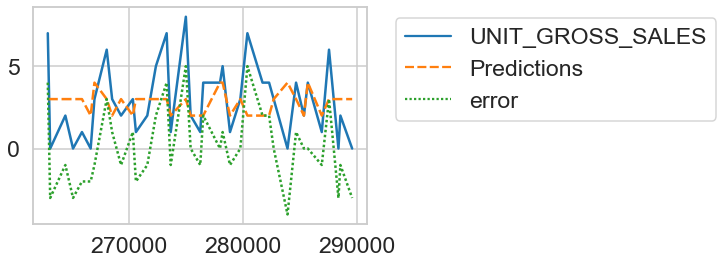

In [66]:

sns.lineplot(data=item1, palette="tab10", linewidth=2.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Future Work

The next step in the process is to utilize the news vendor model to estimate demand in each store for each item. A simulation can then be run to identify how many deliveries should be schedled throughout the week to minimize waste.